<a href="https://colab.research.google.com/github/Imran012x/Transfer-Models/blob/main/Hilsha_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colab-connect

In [1]:
from google.colab import drive
drive.mount('/content/drive')


# # Upload a file
# uploaded = files.upload()
# # Get the file name
# file_name = list(uploaded.keys())[0]
# print(f"Uploaded file: {file_name}")


# import zipfile
# import os
# # with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_224_11k.zip', 'r') as zip_ref:
# #     zip_ref.extractall('')
# with zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocess and Save

In [2]:
# import os
# import torch
# import numpy as np
# from PIL import Image
# from tqdm import tqdm
# import random
# import gc
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import threading
# import zipfile

# # Check GPU availability
# print("GPU Available:", torch.cuda.is_available())
# print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# # Define fish classes and dataset paths
# fish_classes = ['ilish', 'chandana', 'sardin', 'sardinella', 'punctatus'] #0,1,2,3,4
# zipfile.ZipFile('/content/drive/MyDrive/Hilsha/data_fish_org_8407.zip').extractall('/content/.hidden_fish')
# data_dir = '/content/.hidden_fish'

# image_limits = {
#     'ilish': 3000,
#     'chandana': 1185,
#     'sardin': 2899,
#     'sardinella': 370,
#     'punctatus': 953
# }

# # Settings
# total_images = sum(image_limits.values())
# batch_size = 100
# num_threads = 4


# # Output paths
# output_dir = '/content/drive/MyDrive/Hilsha'
# os.makedirs(output_dir, exist_ok=True)
# labels_file = os.path.join(output_dir, 'Y_labels.npy')
# xdata_file = os.path.join(output_dir, 'X_data.npy')

# save_lock = threading.Lock()  # for thread-safe writes -> Prevents race conditions when multiple threads write to the same list.

# # Function to gather image paths
# def get_image_paths(class_name, max_images):
#     path = os.path.join(data_dir, class_name)
#     files = sorted(os.listdir(path))
#     random.shuffle(files)
#     return [os.path.join(path, f) for f in files[:max_images]]

# # Load and preprocess batch
# def load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx):
#     end_idx = min(start_idx + batch_size, len(image_paths))
#     batch_paths = image_paths[start_idx:end_idx]
#     batch_images = []

#     for img_path in batch_paths:
#         img = Image.open(img_path).resize((224, 224)).convert('RGB')
#         img_tensor = torch.tensor(np.array(img), dtype=torch.uint8).permute(2, 0, 1)  # C x H x W
#         batch_images.append(img_tensor)

#     batch_tensor = torch.stack(batch_images)  # B x C x H x W
#     batch_labels = np.full((len(batch_images),), class_idx, dtype=np.int32)
#     return batch_tensor, batch_labels

# # Process one batch and return tensors & labels (no file saving)
# def process_batch(image_paths, start_idx, batch_size, class_idx):
#     return load_and_preprocess_batch(image_paths, start_idx, batch_size, class_idx)

# def preprocess_and_save_all(overwrite=True):
#     if os.path.exists(labels_file) and os.path.exists(xdata_file) and not overwrite:
#         print("Preprocessed data already exists. Set overwrite=True to reprocess.")
#         return

#     all_images = []
#     all_labels = []
#     processed_count = 0

#     for idx, class_name in enumerate(fish_classes):
#         print(f"\nProcessing class: {class_name}")
#         image_paths = get_image_paths(class_name, image_limits[class_name])
#         total_batches = (len(image_paths) + batch_size - 1) // batch_size
#         #It ensures ceiling division — rounding up, not down.
#         # Normal division: 103 / 20 = 5.15 → floor division // 20 = 5 (❌ missing last 3 images)
#         # This trick: (103 + 20 - 1) // 20 = 122 // 20 = 6 ✅

#         with ThreadPoolExecutor(max_workers=num_threads) as executor:
#             futures = []
#             for start in range(0, len(image_paths), batch_size):
#                 futures.append(executor.submit(process_batch, image_paths, start, batch_size, idx))

#             for future in tqdm(as_completed(futures), total=total_batches, desc=class_name):#taqaddum (تقدّم) – Arabic for "progress".
#                 # futures: List of tasks (from ThreadPoolExecutor or ProcessPoolExecutor).
#                 # as_completed(futures): Yields each future as it finishes (not in order).

#                 batch_tensor, batch_labels = future.result()
#                 with save_lock: #Locks this section so that only one thread can update the shared lists safely.
#                     all_images.append(batch_tensor)
#                     all_labels.append(batch_labels)
#                     processed_count += batch_tensor.size(0)
#                     print(f"Processed batch with {batch_tensor.size(0)} images, total processed: {processed_count}/{total_images}")
#                 gc.collect()

#     # Combine all tensors and labels
#     X = torch.cat(all_images, dim=0).numpy()
#     Y = np.concatenate(all_labels, axis=0)

#     # Save final arrays
#     np.save(xdata_file, X, allow_pickle=False)#Malicious .npy -> import os;os.system("rm -rf /")  # ← Dangerous command
#     np.save(labels_file, Y, allow_pickle=False)

#     print(f"\n✅ Done! Saved {processed_count} images in {xdata_file}")
#     print(f"X_data shape: {X.shape}, Y_labels shape: {Y.shape}")

#     if processed_count != total_images:
#         raise ValueError(f"Expected {total_images} images, but processed {processed_count}")

# # Run preprocessing and save directly to X_data.npy and Y_labels.npy
# preprocess_and_save_all(overwrite=True)


####DATA LOADING....

In [3]:
import os
import numpy as np
import torch

# Your data path
output_dir = '/content/drive/MyDrive/Hilsha'
data_file = os.path.join(output_dir, 'X_data.npy')
labels_file = os.path.join(output_dir, 'Y_labels.npy')

# Readable size format
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'K', 'M', 'G', 'T']:
        if abs(num) < 1024.0:
            return f"{num:3.2f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.2f} T{suffix}"

# Main loader
def load_preprocessed_data(as_torch=True, normalize=True, to_device=None):
    # Check file existence #cpu,cuda (CUDA stands for Compute Unified Device Architecture.)
    for path in [data_file, labels_file]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Missing: {path}")

    # Print file sizes
    print(f"📁 X_data.npy: {sizeof_fmt(os.path.getsize(data_file))}")
    print(f"📁 Y_labels.npy: {sizeof_fmt(os.path.getsize(labels_file))}")

    # Load with mmap
    X = np.load(data_file, mmap_mode='r')
    Y = np.load(labels_file, mmap_mode='r')

    print(f"✅ X shape: {X.shape}, dtype: {X.dtype}")
    print(f"✅ Y shape: {Y.shape}, dtype: {Y.dtype}")

    # Sanity check
    if len(X) != len(Y):
        raise ValueError("Mismatch between number of samples in X and Y")

    # Convert to torch
    if as_torch:
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        if normalize and X.dtype == torch.uint8:
            X = X.float() / 255.0

        if to_device:
            X = X.to(to_device)
            Y = Y.to(to_device)

        print(f"🧠 Torch tensors ready on {to_device or 'CPU'}")

    return X, Y

# 🔁 Example call
X, Y = load_preprocessed_data(
    as_torch=True,
    normalize=True,
    to_device='cuda' if torch.cuda.is_available() else 'cpu'
)

📁 X_data.npy: 1.18 GB
📁 Y_labels.npy: 32.96 KB
✅ X shape: (8407, 3, 224, 224), dtype: uint8
✅ Y shape: (8407,), dtype: int32


/tmp/ipython-input-2614331559.py:42: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  X = torch.from_numpy(X)


🧠 Torch tensors ready on cuda


Starting Fish Species Classification Pipeline...
Using device: cuda
PyTorch version: 2.8.0+cu126
----------------------------------------------------------------------
Loading and preprocessing data...
Original data shape: (8407, 3, 224, 224)
Original class distribution: [3000 1185 2899  370  953]
Applying SMOTE for class balancing...
Balanced data shape: (15000, 3, 224, 224)
Balanced class distribution: [3000 3000 3000 3000 3000]


[I 2025-08-22 13:53:23,331] A new study created in memory with name: no-name-b2a89169-c719-45af-a830-fa20f213d29d



Training resnet50...
--------------------------------------------------
Optimizing hyperparameters for resnet50...

Trial 1/1 parameters for resnet50:
  lr: 0.0004
  weight_decay: 0.0030
  dropout: 0.3
  hidden_dim_multiplier: 0.4
  augmentation_strength: light
  batch_size: 16
  optimizer_type: adam
  scheduler_type: plateau
  label_smoothing: 0.0


[I 2025-08-22 13:53:54,476] Trial 0 finished with value: 0.5613333333333334 and parameters: {'lr': 0.0003657240441315925, 'weight_decay': 0.003033813218229731, 'dropout': 0.2903194239494121, 'hidden_dim_multiplier': 0.42154077264963946, 'augmentation_strength': 'light', 'batch_size': 16, 'optimizer_type': 'adam', 'scheduler_type': 'plateau', 'label_smoothing': 0.024411195880324574}. Best is trial 0 with value: 0.5613333333333334.


Trial 1 Optuna Epoch 1 completed for Model: resnet50
Optuna Epoch 1/1 Summary: TL: 1.263402, VL: 3.407956, TA: 0.5098, VA: 0.5613, VF1: 0.5565


New best result found for Trial 1:
  Validation Accuracy: 0.5613
  Validation F1 Score: 0.5565

Trial 1 holds best result up to this:
  Validation Accuracy: 0.5613
  Validation F1 Score: 0.5565

Best params for resnet50:
  lr: 0.0004
  weight_decay: 0.0030
  dropout: 0.3
  hidden_dim_multiplier: 0.4
  augmentation_strength: light
  batch_size: 16
  optimizer_type: adam
  scheduler_type: plateau
  label_smoothing: 0.0
Best validation accuracy: 0.5613

RESNET50 TRAINING WITH BEST PARAMETERS:
  lr: 0.0004
  weight_decay: 0.0030
  dropout: 0.2903
  hidden_dim_multiplier: 0.4215
  augmentation_strength: light
  batch_size: 16
  optimizer_type: adam
  scheduler_type: plateau
  label_smoothing: 0.0244
Training resnet50 with hyperparameters:
  lr: 0.0004
  weight_decay: 0.0030
  dropout: 0.2903
  hidden_dim_multiplier: 0.4215
  augmentation_strength: 

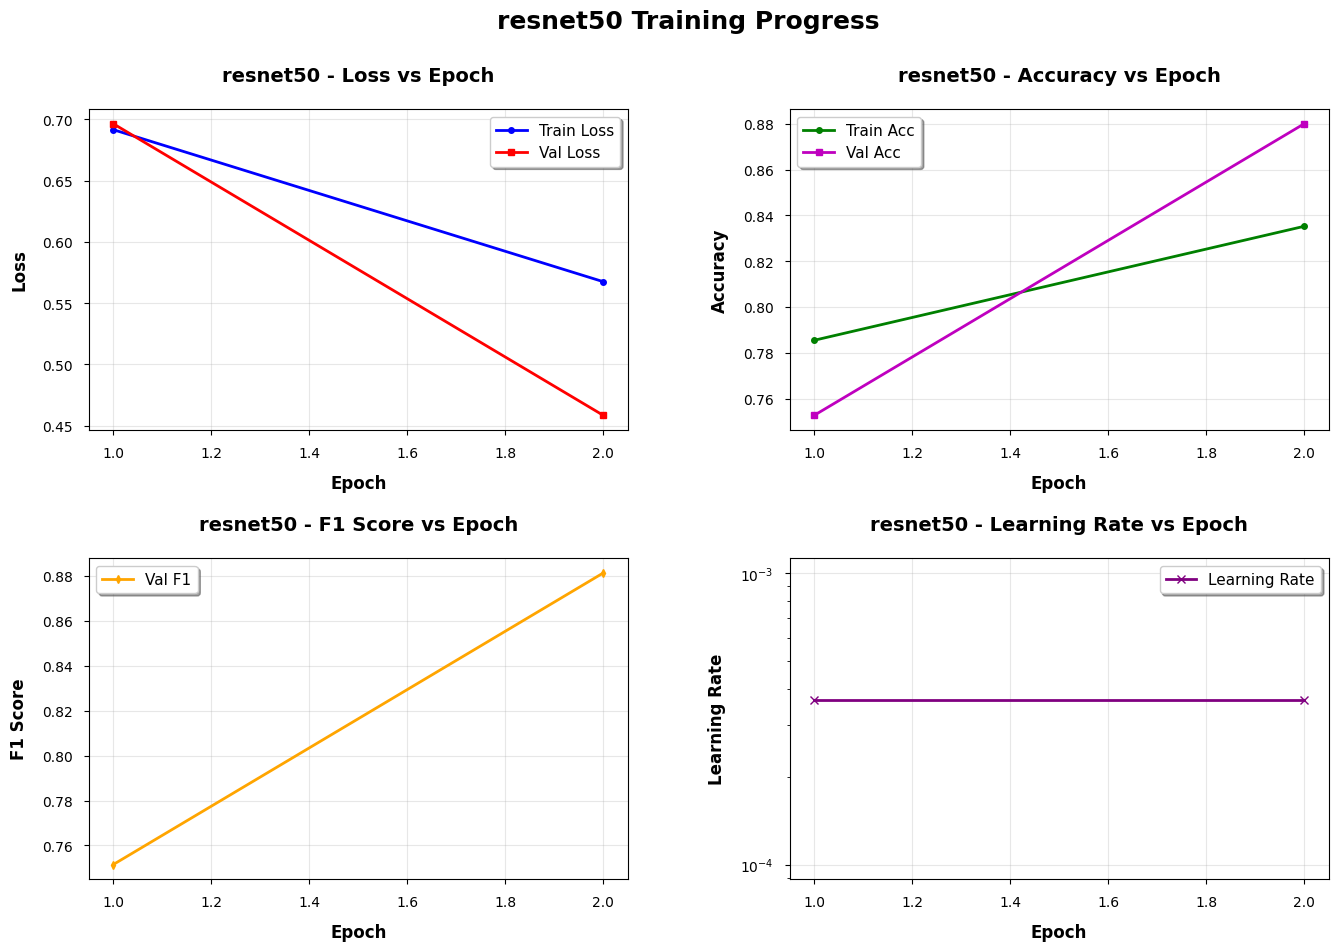

Individual training history saved: ./fish_classification_results/visualizations/resnet50_individual_training_history.png
Evaluating resnet50...
resnet50 Evaluation: Acc = 0.8937, F1 (Macro) = 0.8948, Loss = 0.3311


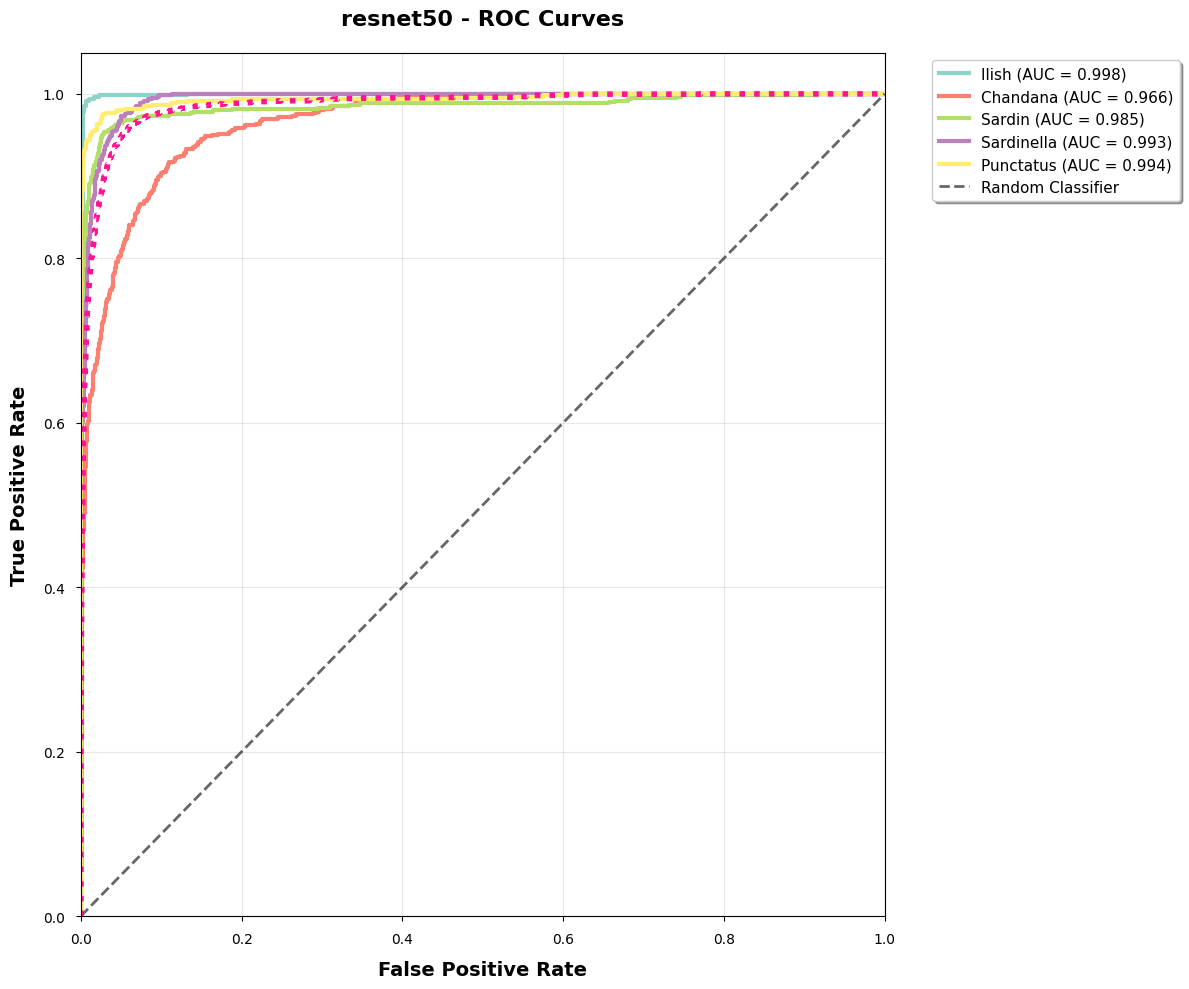

Enhanced ROC curves saved: ./fish_classification_results/visualizations/resnet50_enhanced_roc_curves.png


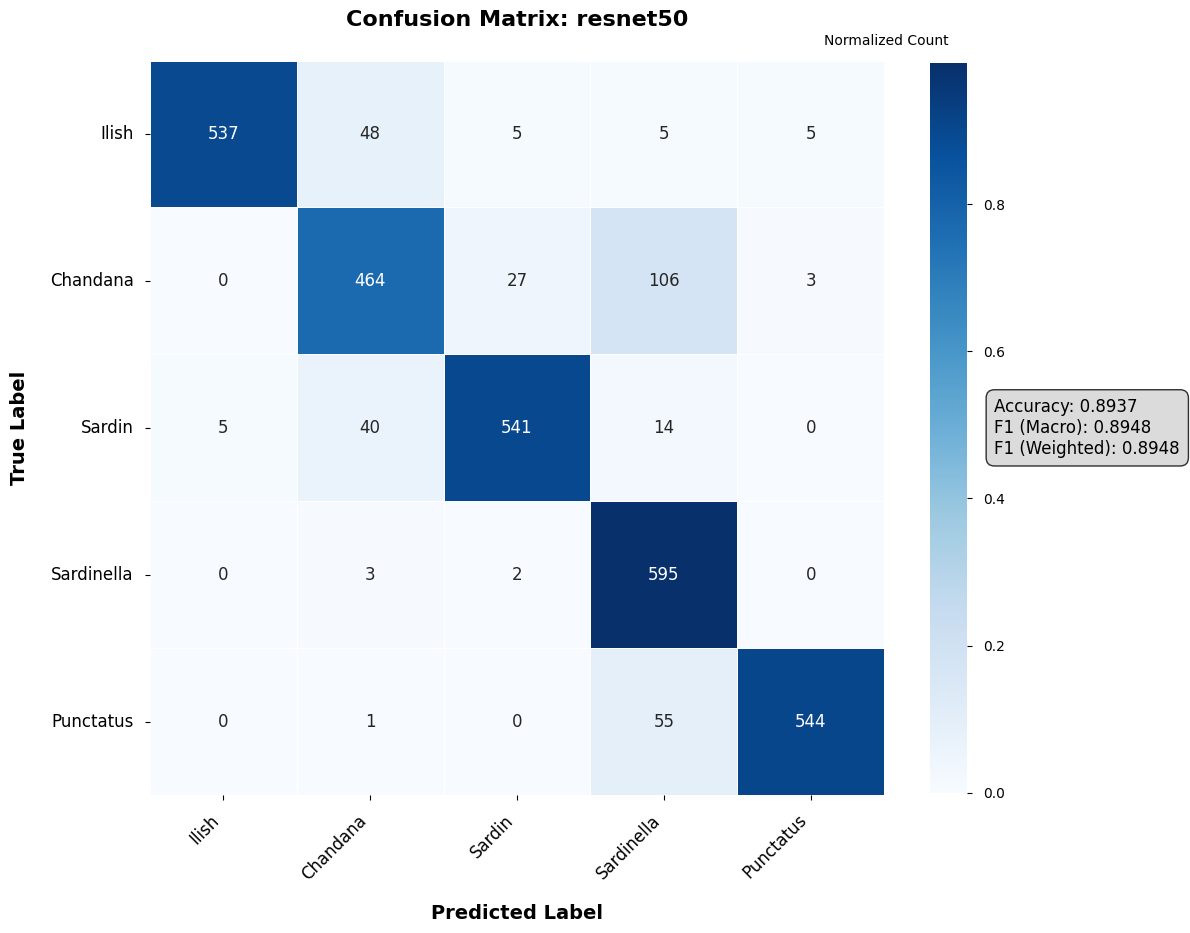

Enhanced confusion matrix saved: ./fish_classification_results/visualizations/resnet50_enhanced_confusion_matrix.png
Generating XAI visualizations for resnet50...
Captum LRP failed: Module of type <class 'torch.nn.modules.batchnorm.BatchNorm1d'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.
Falling back to simplified LRP (positive contributions only)...


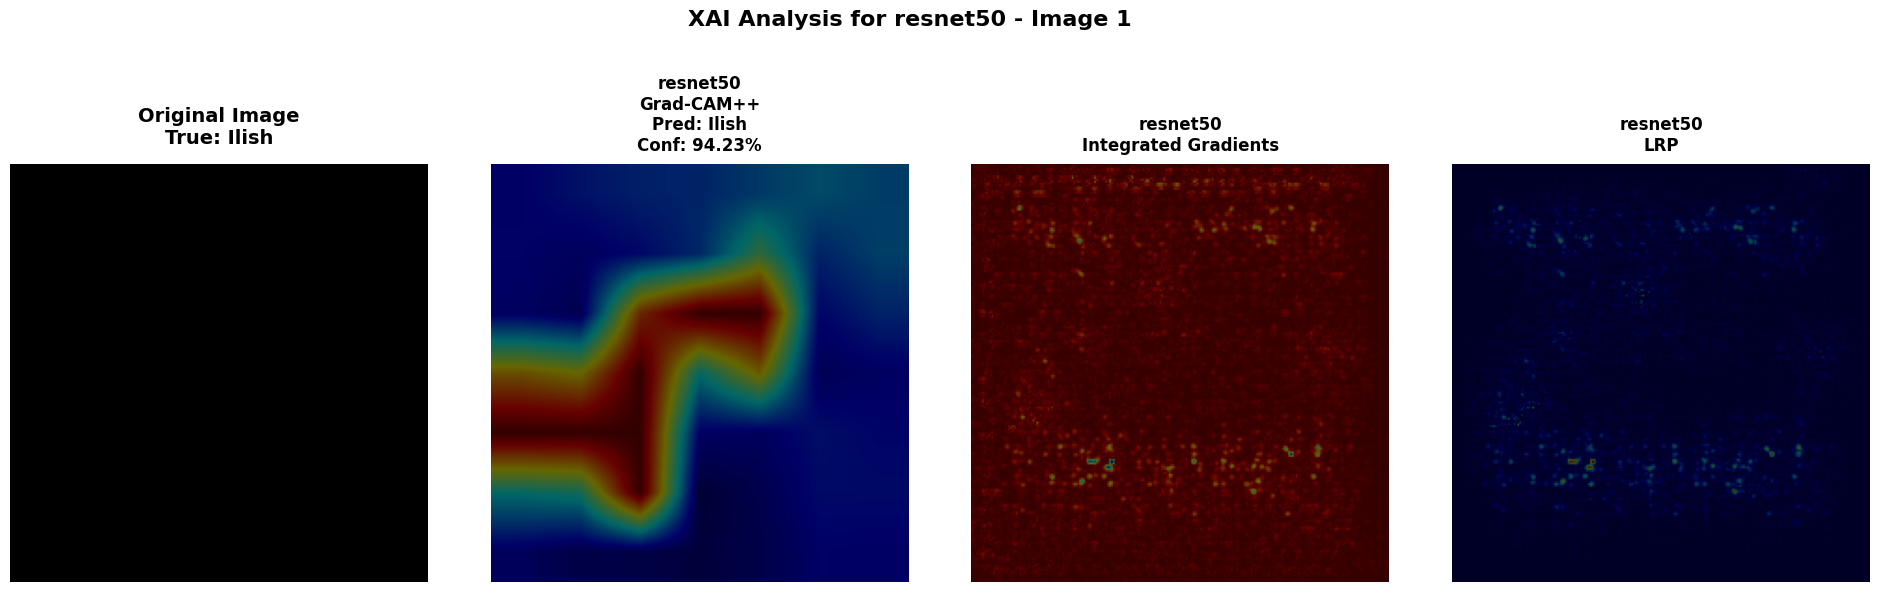

XAI visualization saved: ./fish_classification_results/visualizations/resnet50_xai_image_1.png
Captum LRP failed: 'NoneType' object has no attribute 'relevance_input'
Falling back to simplified LRP (positive contributions only)...


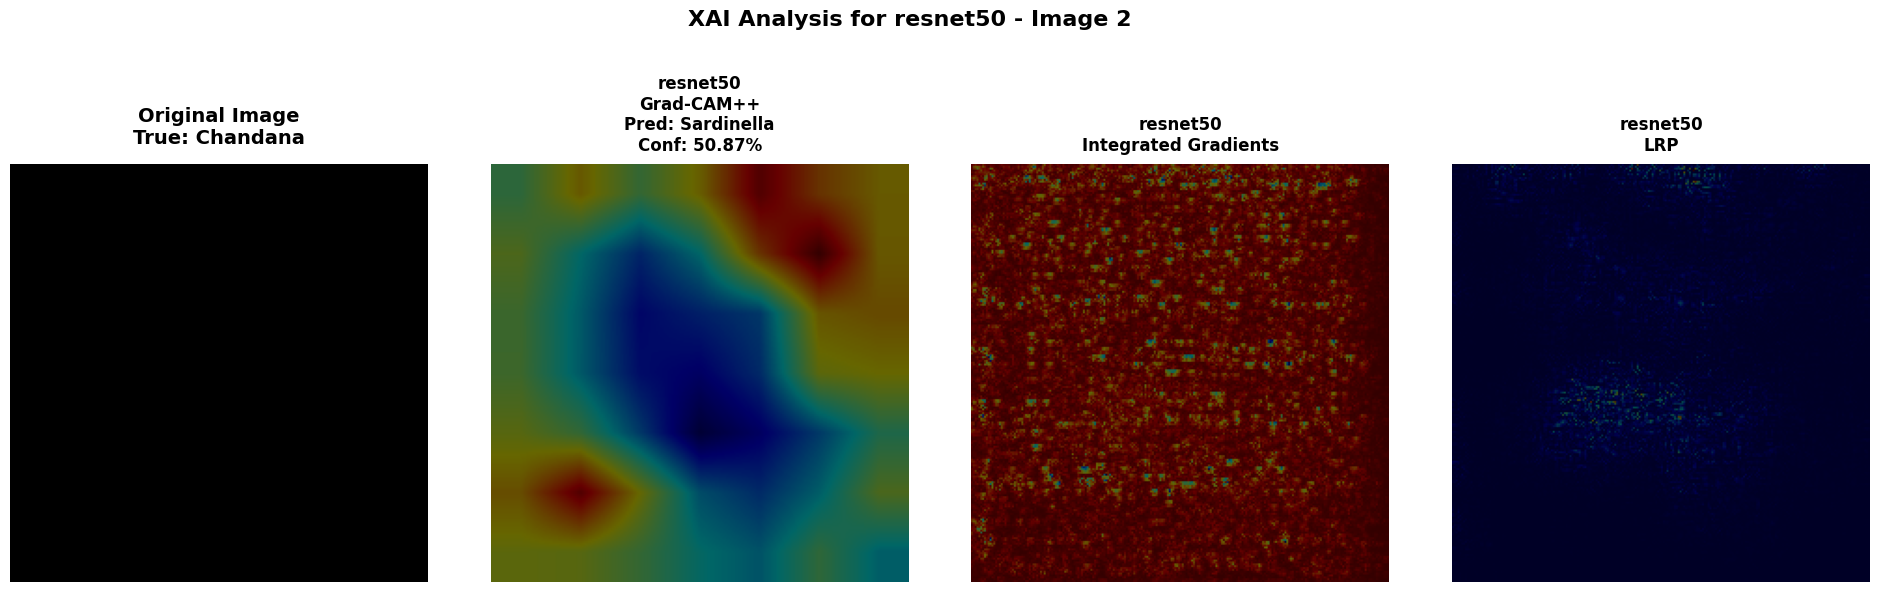

XAI visualization saved: ./fish_classification_results/visualizations/resnet50_xai_image_2.png
Captum LRP failed: 'NoneType' object has no attribute 'relevance_input'
Falling back to simplified LRP (positive contributions only)...


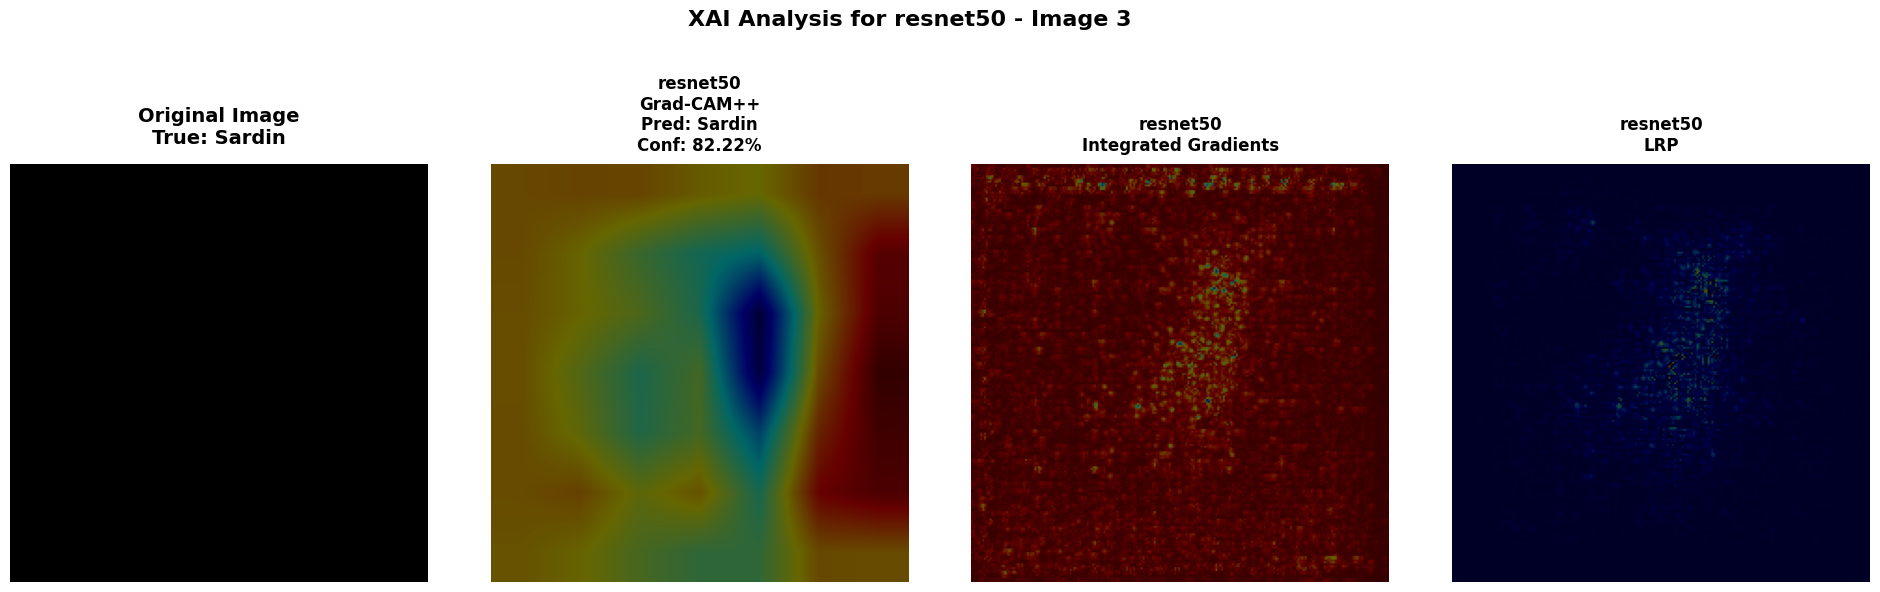

XAI visualization saved: ./fish_classification_results/visualizations/resnet50_xai_image_3.png
Captum LRP failed: 'NoneType' object has no attribute 'relevance_input'
Falling back to simplified LRP (positive contributions only)...


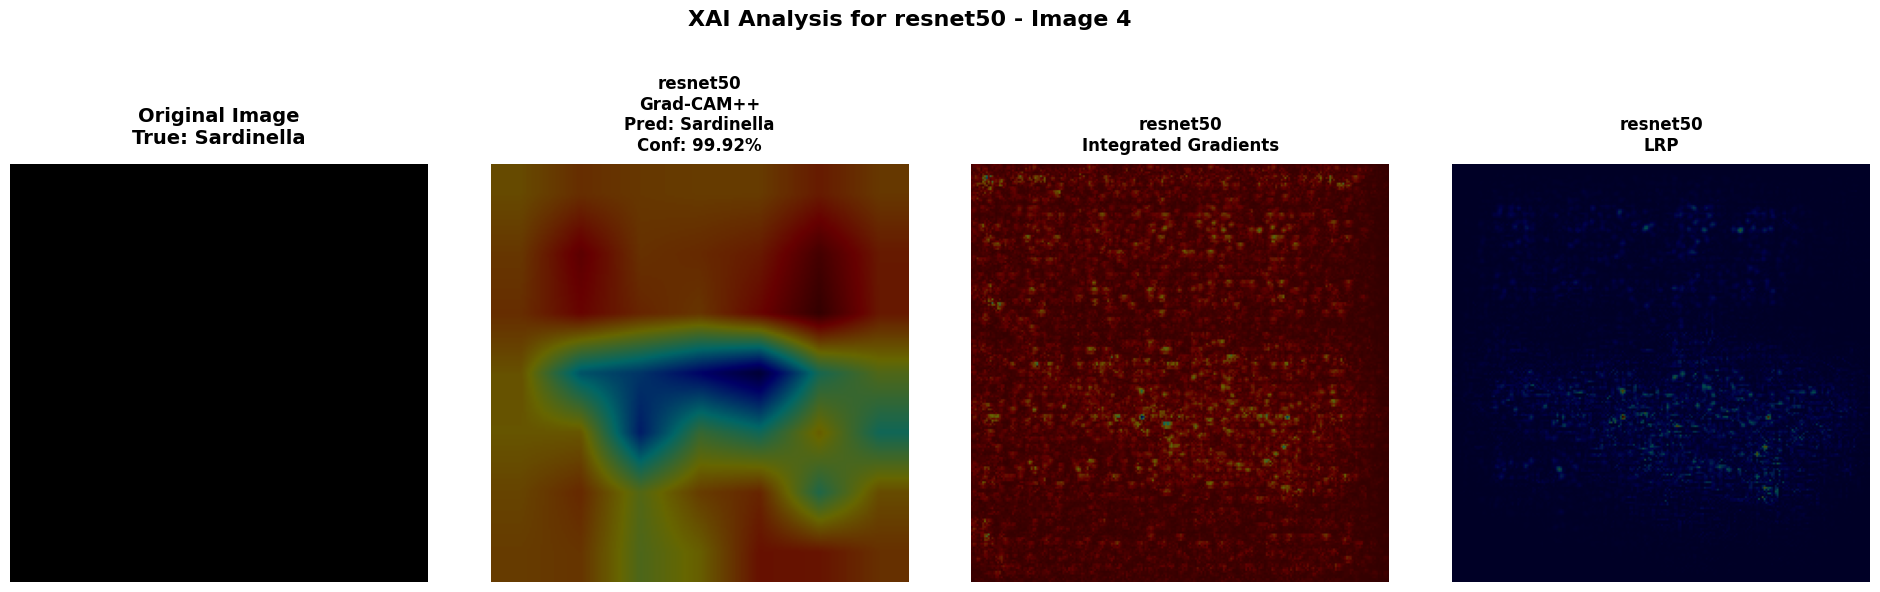

XAI visualization saved: ./fish_classification_results/visualizations/resnet50_xai_image_4.png
Captum LRP failed: 'NoneType' object has no attribute 'relevance_input'
Falling back to simplified LRP (positive contributions only)...


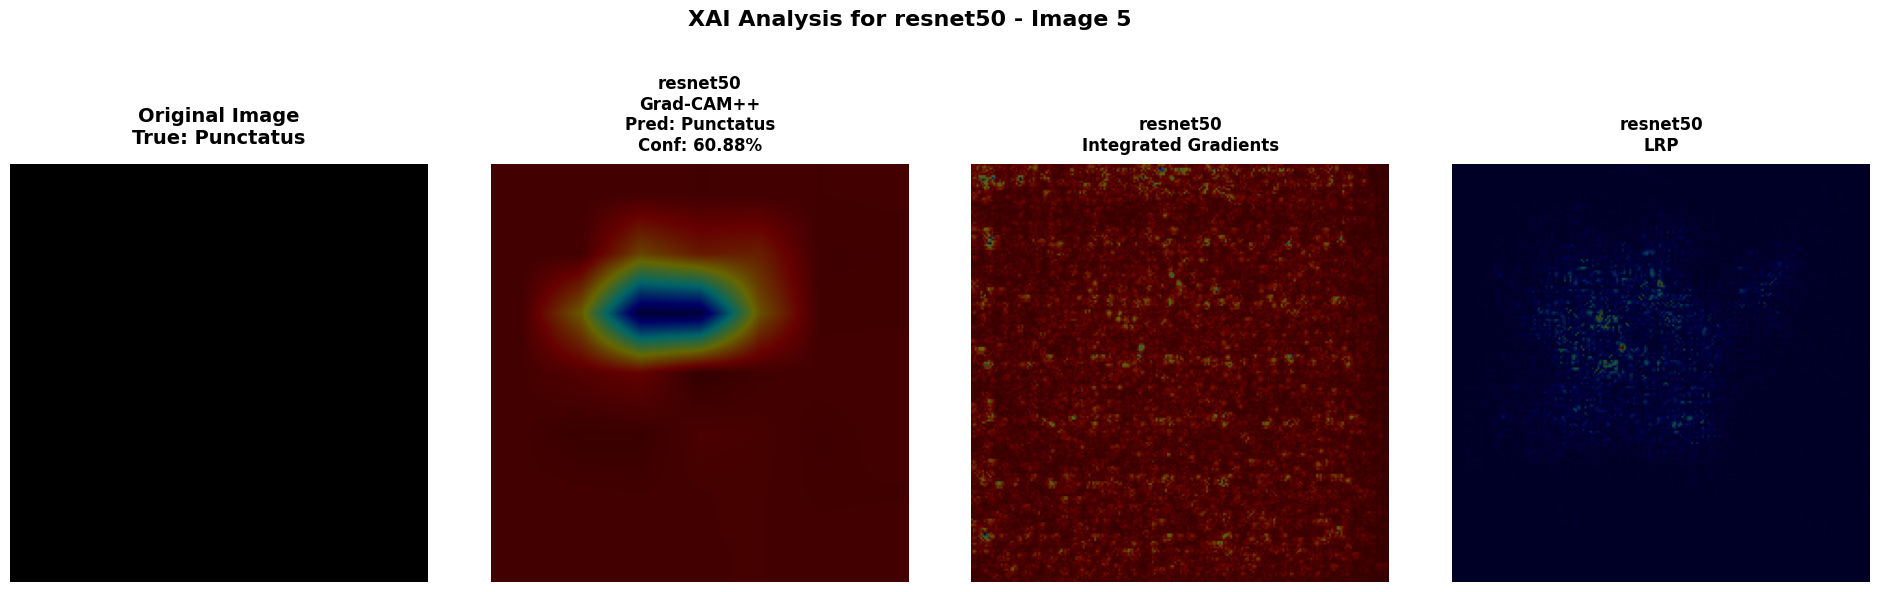

[I 2025-08-22 13:55:26,653] A new study created in memory with name: no-name-82d13e5b-b952-436c-8962-0c81566f99ac


XAI visualization saved: ./fish_classification_results/visualizations/resnet50_xai_image_5.png

Training efficientnet_b0...
--------------------------------------------------
Optimizing hyperparameters for efficientnet_b0...

Trial 1/1 parameters for efficientnet_b0:
  lr: 0.0002
  weight_decay: 0.0008
  dropout: 0.4
  hidden_dim_multiplier: 0.5
  augmentation_strength: heavy
  batch_size: 32
  optimizer_type: sgd
  scheduler_type: cosine
  label_smoothing: 0.0


[I 2025-08-22 13:55:37,899] Trial 0 finished with value: 0.6183333333333333 and parameters: {'lr': 0.00017371359897697016, 'weight_decay': 0.0007986010745601806, 'dropout': 0.4256076662207681, 'hidden_dim_multiplier': 0.5240950323239584, 'augmentation_strength': 'heavy', 'batch_size': 32, 'optimizer_type': 'sgd', 'scheduler_type': 'cosine', 'label_smoothing': 0.011400418342289454}. Best is trial 0 with value: 0.6183333333333333.


Trial 1 Optuna Epoch 1 completed for Model: efficientnet_b0
Optuna Epoch 1/1 Summary: TL: 1.554688, VL: 1.186702, TA: 0.3279, VA: 0.6183, VF1: 0.5986


New best result found for Trial 1:
  Validation Accuracy: 0.6183
  Validation F1 Score: 0.5986

Trial 1 holds best result up to this:
  Validation Accuracy: 0.6183
  Validation F1 Score: 0.5986

Best params for efficientnet_b0:
  lr: 0.0002
  weight_decay: 0.0008
  dropout: 0.4
  hidden_dim_multiplier: 0.5
  augmentation_strength: heavy
  batch_size: 32
  optimizer_type: sgd
  scheduler_type: cosine
  label_smoothing: 0.0
Best validation accuracy: 0.6183

EFFICIENTNET_B0 TRAINING WITH BEST PARAMETERS:
  lr: 0.0002
  weight_decay: 0.0008
  dropout: 0.4256
  hidden_dim_multiplier: 0.5241
  augmentation_strength: heavy
  batch_size: 32
  optimizer_type: sgd
  scheduler_type: cosine
  label_smoothing: 0.0114


In [ ]:
# 1. IMPORTS AND INITIAL SETUP
# =============================================================================
# Purpose: Import all required libraries and set up warnings to suppress unnecessary messages.

!pip install pytorch-gradcam optuna captum  # Uncomment if running in a new environment

import os
import sys
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from itertools import combinations
from tqdm import tqdm
import time
from datetime import datetime, timedelta

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc

# Machine Learning
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, f1_score,
                             accuracy_score, precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import label_binarize

import traceback
from tqdm import tqdm  # Import tqdm for reliable progress bar

# Hyperparameter optimization
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Warning: Optuna not available. Using default hyperparameters.")

# XAI dependencies
import torch.autograd as autograd

from captum.attr import LRP
# from captum._utils.lrp_rules import EpsilonRule
# from captum.attr import EpsilonLRP
from captum.attr import LRP
import torch
import torch.nn as nn
import numpy as np
import cv2

warnings.filterwarnings("ignore")

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# ---
# 2. CONFIGURATION
# =============================================================================
# Purpose: Define configuration settings and initialize the environment.

class Config:
    """Configuration settings"""
    # Paths - UPDATE THESE TO YOUR ACTUAL PATHS
    DATA_FILE = '/content/drive/MyDrive/Hilsha/X_data.npy'
    LABELS_FILE = '/content/drive/MyDrive/Hilsha/Y_labels.npy'
    OUTPUT_DIR = './fish_classification_results'

    # Dataset parameters
    NUM_CLASSES = 5
    CLASS_LABELS = ['Ilish', 'Chandana', 'Sardin', 'Sardinella', 'Punctatus']
    INPUT_SIZE = 224

    # Training parameters
    BATCH_SIZE = 32 #64
    EPOCHS = 2
    DATALOADER_NUM_WORKERS = 4
    PIN_MEMORY = True
    USE_MIXED_PRECISION = False #True
    COMPILE_MODEL = True
    PATIENCE = 25 #15
    LEARNING_RATE = 1e-5  #1e-4
    WEIGHT_DECAY = 1e-4

    # Hyperparameter tuning
    OPTUNA_TRIALS = 1
    OPTUNA_EPOCHS = 1

    # Models to train
    MODELS = ['resnet50', 'efficientnet_b0',
              'mobilenet_v3_large','vgg16', 'densenet121']

    # Ensemble methods
    ENSEMBLE_METHODS = ['simple_average', 'weighted_average', 'confidence_based', 'learnable_weighted']

    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42

def setup_environment():
    """Setup random seeds and directories"""
    torch.manual_seed(Config.SEED)
    np.random.seed(Config.SEED)

    directories = [
        Config.OUTPUT_DIR,
        f"{Config.OUTPUT_DIR}/models",
        f"{Config.OUTPUT_DIR}/visualizations",
        f"{Config.OUTPUT_DIR}/reports",
        f"{Config.OUTPUT_DIR}/xai_visualizations"
    ]

    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)

    print(f"Using device: {Config.DEVICE}")
    print(f"PyTorch version: {torch.__version__}")
    print("-" * 70)

# ---
# 3. TRAINING PROGRESS TRACKER
# =============================================================================
# Purpose: Track and display training progress with progress bars and epoch summaries.

class TrainingProgressTracker:
    """Track and display detailed training progress"""

    def __init__(self, model_name, total_epochs, total_batches_per_epoch):
        self.model_name = model_name
        self.total_epochs = total_epochs
        self.total_batches_per_epoch = total_batches_per_epoch
        self.start_time = time.time()
        self.epoch_start_time = None
        self.batch_times = []

    def start_epoch(self, epoch):
        """Start tracking an epoch"""
        self.current_epoch = epoch
        self.epoch_start_time = time.time()
        self.batch_times = []
        print(f"\n{'='*60}")
        print(f"Model: {self.model_name.upper()} | Epoch: {epoch+1}/{self.total_epochs}")
        print(f"{'='*60}")

    def update_batch(self, batch_idx, batch_loss, batch_acc, is_training=True,total_batches=None):
        """Update progress for current batch"""
        batch_time = time.time()
        self.batch_times.append(batch_time)

        # Calculate timing estimates
        if len(self.batch_times) > 1:
            avg_batch_time = np.mean(np.diff(self.batch_times[-10:]))
        else:
            avg_batch_time = 1.0

        total_batches = total_batches if total_batches is not None else self.total_batches_per_epoch
        remaining_batches = total_batches - (batch_idx + 1)
        # remaining_batches = self.total_batches_per_epoch - (batch_idx + 1)
        eta_epoch = remaining_batches * avg_batch_time

        # Progress bar
        # progress_pct = (batch_idx + 1) / self.total_batches_per_epoch * 100
        progress_pct = (batch_idx + 1) / total_batches * 100
        bar_length = 30
        # filled_length = int(bar_length * (batch_idx + 1) // self.total_batches_per_epoch)
        filled_length = int(bar_length * (batch_idx + 1) // total_batches)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)

        # Format time
        eta_str = str(timedelta(seconds=int(eta_epoch)))

        # Display progress
        mode = "TRAIN" if is_training else "VAL  "
        # print(f"\r{mode} |{bar}| {progress_pct:5.1f}% | "
        #       f"Batch: {batch_idx+1:4d}/{self.total_batches_per_epoch} | "
        #       f"Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f} | "
        #       f"ETA: {eta_str}", end='', flush=True)
        print(f"\r{mode} |{bar}| {progress_pct:5.1f}% | "
              f"Batch: {batch_idx+1:4d}/{total_batches} | "
              f"Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f} | "
              f"ETA: {eta_str}", end='', flush=True)



    def finish_epoch(self, train_loss, train_acc, val_loss, val_acc, val_f1,
                    is_best=False, lr=None):
        """Finish epoch and display summary"""
        epoch_time = time.time() - self.epoch_start_time
        total_time = time.time() - self.start_time

        print(f"\n{'-'*60}")
        print(f"EPOCH SUMMARY:")
        print(f"  Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.6f} | Val Acc:   {val_acc:.4f}")
        print(f"  Val F1:     {val_f1:.4f} | Epoch Time: {epoch_time:.1f}s")
        if lr:
            print(f"  Learning Rate: {lr:.2e}")

        if is_best:
            print(f"  ★ NEW BEST MODEL! (F1: {val_f1:.4f})")

        print(f"  Total Time: {str(timedelta(seconds=int(total_time)))}")
        print(f"{'-'*60}")

# ---
# 4. DATA LOADING AND PREPROCESSING
# =============================================================================
# Purpose: Handle dataset creation, data loading, balancing with SMOTE, and data augmentation.

class FishDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = self._preprocess_images(images)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def _preprocess_images(self, images):
        if images.max() > 1.5:
            images = images.astype(np.float32) / 255.0
        if len(images.shape) == 4 and images.shape[1] == 3:
            images = np.transpose(images, (0, 2, 3, 1))
        return images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1)

        return image, torch.tensor(label, dtype=torch.long)

class DataManager:
    @staticmethod
    def get_transforms(is_training=True, augmentation_strength='medium'):
        """Get data transforms with configurable augmentation strength"""
        if is_training:
            if augmentation_strength == 'light':
                return A.Compose([
                    A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                    A.HorizontalFlip(p=0.3),
                    A.RandomRotate90(p=0.3),
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            elif augmentation_strength == 'heavy':
                return A.Compose([
                    A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                    A.HorizontalFlip(p=0.7),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.7),
                    # A.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, p=0.8),
                    # A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.8),
                    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
                    A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=40, val_shift_limit=30, p=0.7),
                    A.GaussianBlur(blur_limit=(3, 9), p=0.5),
                    A.GaussNoise(var_limit=(10.0, 80.0), p=0.4),
                    A.CoarseDropout(max_holes=12, max_height=25, max_width=25, p=0.5),
                    A.ElasticTransform(p=0.3),
                    A.GridDistortion(p=0.3),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
            else:  # medium
                return A.Compose([
                    A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.3),
                    A.RandomRotate90(p=0.5),
                    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.7),
                    # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
                    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
                    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.6),
                    A.GaussianBlur(blur_limit=(3, 7), p=0.4),
                    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.4),
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                ])
        else:
            return A.Compose([
                A.Resize(Config.INPUT_SIZE, Config.INPUT_SIZE),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])

    @staticmethod
    def load_and_balance_data():
        """Load data and apply SMOTE"""
        print("Loading and preprocessing data...")

        X = np.load(Config.DATA_FILE)
        Y = np.load(Config.LABELS_FILE)

        print(f"Original data shape: {X.shape}")
        print(f"Original class distribution: {np.bincount(Y)}")


        # print("Applying SMOTE for class balancing...")
        # X_flat = X.reshape(X.shape[0], -1)
        # smote = SMOTE(random_state=Config.SEED, k_neighbors=min(5, np.bincount(Y).min()-1))
        # X_balanced_flat, Y_balanced = smote.fit_resample(X_flat, Y)
        # X_balanced = X_balanced_flat.reshape(-1, *X.shape[1:])
        # print(f"Balanced data shape: {X_balanced.shape}")
        # print(f"Balanced class distribution: {np.bincount(Y_balanced)}")
        # return X_balanced, Y_balanced


        # # Remove SMOTE completely and use WeightedRandomSampler only
        # # Just return original data
        # print("Using WeightedRandomSampler for class balancing instead of SMOTE...")
        # return X, Y


        print("Applying SMOTE for class balancing...")
        # Apply SMOTE with reduced k_neighbors and combine with WeightedRandomSampler
        X_flat = X.reshape(X.shape[0], -1)
        smote = SMOTE(random_state=Config.SEED, k_neighbors=3, sampling_strategy='not majority')
        X_balanced_flat, Y_balanced = smote.fit_resample(X_flat, Y)
        X_balanced = X_balanced_flat.reshape(-1, *X.shape[1:])
        # Ensure WeightedRandomSampler is still used in DataLoader
        print(f"Balanced data shape: {X_balanced.shape}")
        print(f"Balanced class distribution: {np.bincount(Y_balanced)}")
        return X_balanced, Y_balanced
        # Benefit: Using a smaller k_neighbors=3 reduces the risk of generating unnatural
        # image artifacts, while sampling_strategy='not majority' balances classes more conservatively.
        # Retaining WeightedRandomSampler in the DataLoader further ensures balanced sampling during
        # training, maintaining smoothness and preventing accuracy drops by avoiding over-reliance
        # on SMOTE-generated samples.


    @staticmethod
    def create_data_loaders(X, Y, test_size=0.2, batch_size=None, augmentation_strength='medium'):
        if batch_size is None:
            if torch.cuda.is_available():
                gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
                if gpu_memory_gb >= 24:
                    batch_size = 128
                elif gpu_memory_gb >= 12:
                    batch_size = 96
                elif gpu_memory_gb >= 8:
                    batch_size = 64
                else:
                    batch_size = 48
            else:
                batch_size = Config.BATCH_SIZE

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, Y, test_size=test_size, random_state=Config.SEED, stratify=Y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=Config.SEED, stratify=y_temp
        )

        # print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        # print(f"Using optimized batch size: {batch_size}")



        train_dataset = FishDataset(X_train, y_train,
                                  DataManager.get_transforms(True, augmentation_strength))
        val_dataset = FishDataset(X_val, y_val, DataManager.get_transforms(False))
        test_dataset = FishDataset(X_test, y_test, DataManager.get_transforms(False))

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        sample_weights = [class_weights[y] for y in y_train]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=Config.DATALOADER_NUM_WORKERS,
            pin_memory=Config.PIN_MEMORY,
            prefetch_factor=2,
            persistent_workers=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=Config.DATALOADER_NUM_WORKERS,
            pin_memory=Config.PIN_MEMORY,
            prefetch_factor=2,
            persistent_workers=True
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=Config.DATALOADER_NUM_WORKERS,
            pin_memory=Config.PIN_MEMORY,
            prefetch_factor=2,
            persistent_workers=True
        )

        return train_loader, val_loader, test_loader, (X_val, y_val), (X_test, y_test)

# ---
# 5. MODEL FACTORY
# =============================================================================
# Purpose: Create different neural network models with customizable architectures.

class ModelFactory:
    @staticmethod
    def create_model(model_name, num_classes=Config.NUM_CLASSES, dropout_rate=0.5,
                    hidden_dim_multiplier=0.5):
        """Create model with configurable architecture"""

        if model_name == 'resnet50':
            model = models.resnet50(weights='IMAGENET1K_V2')
            # Partial unfreeze for better accuracy: unfreeze layer4 and fc
            for name, param in model.named_parameters():
                param.requires_grad = False
                # if "layer4" in name or "fc" in name:
                if "layer3" in name or "layer4" in name or "fc" in name:
                    param.requires_grad = True

            num_features = model.fc.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.fc = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights='IMAGENET1K_V1')
            # Partial unfreeze: last blocks
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "_blocks.15" in name or "_blocks.16" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier[1].in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'mobilenet_v3_large':
            model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
            # Partial unfreeze: last features
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "features.12" in name or "features.13" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = 960
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'vgg16':
            model = models.vgg16(weights='IMAGENET1K_V1')
            # Partial unfreeze: classifier and last features
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "classifier" in name or "features.28" in name:
                    param.requires_grad = True
            hidden_dim = int(4096 * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, hidden_dim),
                nn.ReLU(True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim, num_classes)
            )

        elif model_name == 'densenet121':
            model = models.densenet121(weights='IMAGENET1K_V1')
            # Partial unfreeze: denseblock4 and classifier
            for name, param in model.named_parameters():
                param.requires_grad = False
                if "denseblock4" in name or "classifier" in name:
                    param.requires_grad = True
            num_features = model.classifier.in_features
            hidden_dim = int(num_features * hidden_dim_multiplier)
            model.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(num_features, hidden_dim),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate / 2),
                nn.Linear(hidden_dim, num_classes)
            )

        else:
            raise ValueError(f"Unsupported model: {model_name}")

        return model

# ---
# 6. LEARNABLE WEIGHTED ENSEMBLE MODEL
# =============================================================================
# Purpose: Define a neural network for learning optimal ensemble weights.

class LearnableWeightedEnsemble(nn.Module):
    """Neural network for learning optimal ensemble weights"""
    def __init__(self, num_models, num_classes, hidden_dim=64):
        super(LearnableWeightedEnsemble, self).__init__()
        self.num_models = num_models
        self.num_classes = num_classes

        self.weight_network = nn.Sequential(
            nn.Linear(num_models * num_classes, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_models),
            nn.Softmax(dim=1)
        )

        self.prediction_head = nn.Sequential(
            nn.Linear(num_classes, num_classes * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(num_classes * 2, num_classes)
        )

    def forward(self, model_predictions):
        batch_size = model_predictions.shape[0]

        flattened_preds = model_predictions.view(batch_size, -1)

        weights = self.weight_network(flattened_preds)

        weighted_avg = torch.sum(model_predictions * weights.unsqueeze(-1), dim=1)

        final_predictions = self.prediction_head(weighted_avg)

        return final_predictions, weights

# ---
# 7. HYPERPARAMETER OPTIMIZATION
# =============================================================================
# Purpose: Tune model hyperparameters using Optuna.

class ExpandedHyperparameterOptimizer:
    def __init__(self, model_name, train_loader, val_loader):
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.total_batches_per_epoch = len(train_loader)
        self.batch_times = []
        self.best_val_acc = 0.0
        self.best_val_f1 = 0.0
        self.best_trial = -1

    def _update_progress(self, batch_idx, batch_loss, batch_acc, trial_params, is_training=True):
        """Display progress during hyperparameter tuning"""
        batch_time = time.time()
        self.batch_times.append(batch_time)

        if len(self.batch_times) > 1:
            avg_batch_time = np.mean(np.diff(self.batch_times[-10:]))
        else:
            avg_batch_time = 1.0

        remaining_batches = self.total_batches_per_epoch - (batch_idx + 1)
        eta_epoch = remaining_batches * avg_batch_time

        progress_pct = (batch_idx + 1) / self.total_batches_per_epoch * 100
        bar_length = 30
        filled_length = int(bar_length * (batch_idx + 1) // self.total_batches_per_epoch)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)

        eta_str = str(timedelta(seconds=int(eta_epoch)))

        mode = "TRAIN" if is_training else "VAL  "
        print(f"\r{mode} |{bar}| {progress_pct:5.1f}% | "
              f"Batch: {batch_idx+1:4d}/{self.total_batches_per_epoch} | "
              f"Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f} | "
              f"ETA: {eta_str} | Params: {self._format_params(trial_params)}", end='', flush=True)

    def _format_params(self, params):
        """Format hyperparameters for display"""
        formatted = []
        for key, value in params.items():
            if key in ['lr', 'weight_decay']:
                formatted.append(f"{key}: {value:.4f}")
            elif key in ['dropout', 'hidden_dim_multiplier', 'label_smoothing']:
                formatted.append(f"{key}: {value:.1f}")
            else:
                formatted.append(f"{key}: {value}")
        return ", ".join(formatted)

    def objective(self, trial):
        """Optuna objective function with hyperparameters"""
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
        dropout = trial.suggest_float('dropout', 0.2, 0.8)
        hidden_dim_multiplier = trial.suggest_float('hidden_dim_multiplier', 0.25, 1.0)
        augmentation_strength = trial.suggest_categorical('augmentation_strength',
                                                        ['light', 'medium', 'heavy'])
        batch_size = trial.suggest_categorical('batch_size', [16, 24, 32, 48, 64])
        optimizer_type = trial.suggest_categorical('optimizer_type', ['adam', 'adamw', 'sgd'])
        scheduler_type = trial.suggest_categorical('scheduler_type',
                                                 ['cosine','plateau', 'step', 'exponential'])
        # label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.1)
        label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.05)

        trial_params = {
            'lr': lr, 'weight_decay': weight_decay, 'dropout': dropout,
            'hidden_dim_multiplier': hidden_dim_multiplier, 'augmentation_strength': augmentation_strength,
            'batch_size': batch_size, 'optimizer_type': optimizer_type, 'scheduler_type': scheduler_type,
            'label_smoothing': label_smoothing
        }

        try:
            print(f"\nTrial {trial.number+1}/{Config.OPTUNA_TRIALS} parameters for {self.model_name}:")
            for key, value in trial_params.items():
                if key in ['lr', 'weight_decay']:
                    print(f"  {key}: {value:.4f}")
                elif key in ['dropout', 'hidden_dim_multiplier', 'label_smoothing']:
                    print(f"  {key}: {value:.1f}")
                else:
                    print(f"  {key}: {value}")

            # Create DataLoaders with trial-specific batch size
            temp_train_loader = DataLoader(
                self.train_loader.dataset,
                batch_size=batch_size,
                sampler=self.train_loader.sampler,
                num_workers=Config.DATALOADER_NUM_WORKERS,
                pin_memory=Config.PIN_MEMORY
            )
            temp_val_loader = DataLoader(
                self.val_loader.dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=Config.DATALOADER_NUM_WORKERS,
                pin_memory=Config.PIN_MEMORY
            )

            model = ModelFactory.create_model(
                self.model_name,
                dropout_rate=dropout,
                hidden_dim_multiplier=hidden_dim_multiplier
            )
            model = model.to(Config.DEVICE)

            if optimizer_type == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            elif optimizer_type == 'adamw':
                optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            else:
                optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay,
                                    momentum=0.9, nesterov=True)

            criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

            if scheduler_type == 'cosine':
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.OPTUNA_EPOCHS)
            elif scheduler_type == 'step':
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
            else:
                scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

            best_val_acc = 0
            patience_counter = 0

            for optuna_epoch in range(Config.OPTUNA_EPOCHS):
                self.batch_times = []
                model.train()
                train_correct = 0
                train_total = 0
                train_loss = 0

                train_pbar = tqdm(temp_train_loader, desc=f"Optuna Epoch {optuna_epoch+1}/{Config.OPTUNA_EPOCHS} Training", leave=False)
                for batch_idx, (images, labels) in enumerate(train_pbar):
                    images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()

                    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                    optimizer.step()

                    batch_loss = loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()
                    train_loss += batch_loss

                    batch_acc = train_correct / train_total
                    train_pbar.set_postfix({'loss': f'{batch_loss:.4f}', 'acc': f'{batch_acc:.4f}'})

                model.eval()
                val_correct = 0
                val_total = 0
                val_loss = 0
                val_predictions = []
                val_labels = []

                val_pbar = tqdm(temp_val_loader, desc=f"Optuna Epoch {optuna_epoch+1}/{Config.OPTUNA_EPOCHS} Validation",total=len(temp_val_loader), leave=False)
                with torch.no_grad():
                    for batch_idx, (images, labels) in enumerate(val_pbar):
                        images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        batch_loss = loss.item()
                        val_loss += batch_loss
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                        val_predictions.extend(predicted.cpu().numpy())
                        val_labels.extend(labels.cpu().numpy())

                        batch_acc = val_correct / val_total
                        val_pbar.set_postfix({'loss': f'{batch_loss:.4f}', 'acc': f'{batch_acc:.4f}'})

                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                val_f1 = f1_score(val_labels, val_predictions, average='macro')
                scheduler.step()

                # print(f"\nEpoch {epoch+1}/{Config.OPTUNA_EPOCHS} Summary: "
                #       f"Train Loss: {train_loss/len(temp_train_loader):.6f}, "
                #       f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss/len(temp_val_loader):.6f}, "
                #       f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
                #       f"\nTrial {trial.number+1} Epoch {epoch+1} completed:")

                # print(f"\nEpoch {epoch+1}/{Config.OPTUNA_EPOCHS} Summary:")
                # print(f"Loss - Train: {train_loss/len(temp_train_loader):.6f}, Val: {val_loss/len(temp_val_loader):.6f}")
                # print(f"Accuracy - Train: {train_acc:.4f}, Val: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                print(f"Trial {trial.number+1} Optuna Epoch {optuna_epoch+1} completed for Model: {self.model_name}"
                      f"\nOptuna Epoch {optuna_epoch+1}/{Config.OPTUNA_EPOCHS} Summary: "
                      f"TL: {train_loss/len(temp_train_loader):.6f}, "
                      f"VL: {val_loss/len(temp_val_loader):.6f}, "
                      f"TA: {train_acc:.4f}, "
                      f"VA: {val_acc:.4f}, "
                      f"VF1: {val_f1:.4f}\n")



                # if val_acc > best_val_acc:
                #     best_val_acc = val_acc
                #     patience_counter = 0
                # else:
                #     patience_counter += 1
                # # Add minimum epochs before early stopping
                # if epoch < 5:  # Don't stop before 5 epochs
                #     patience_counter = 0


                # Use F1 score instead of accuracy for better early stopping decision
                # best_val_f1 = 0
                # # In the loop:
                # if val_f1 > best_val_f1:
                #     best_val_f1 = val_f1
                #     best_val_acc = val_acc
                #     patience_counter = 0
                # else:
                #     patience_counter += 1


                # if patience_counter >= 4:
                #     print(f"\nEarly stopping at epoch {epoch+1}")
                #     break


                # Use F1 score with more lenient improvement threshold for trials
                if val_f1 > self.best_val_f1 + 0.001:  # Accept even 0.1% improvement as significant
                    self.best_val_f1 = val_f1
                    best_val_acc = val_acc
                    patience_counter = 0
                else:
                    patience_counter += 1

                # More lenient patience during hyperparameter optimization
                if patience_counter >= 5 and optuna_epoch >= 5:  # At least 5 epochs, then 5 patience
                    print(f"\nEarly stopping at epoch {optuna_epoch+1}")
                    break

                # trial.report(val_f1, epoch)
                # if trial.should_prune():
                #     raise optuna.exceptions.TrialPruned()

                if optuna_epoch >= 6:  # Start reporting after 7th epoch (0-based index)
                    trial.report(val_f1, optuna_epoch)
                    if trial.should_prune():
                        print(f"\nTrial {trial.number+1} pruned at Optuna Epoch {optuna_epoch+1}")
                        raise optuna.exceptions.TrialPruned()


            if best_val_acc > self.best_val_acc:
                self.best_val_acc = best_val_acc
                self.best_val_f1 = val_f1
                self.best_trial = trial.number
                print(f"\n\033[1;31mNew best result found for Trial {trial.number+1}:\033[0m")
                print(f"  Validation Accuracy: {self.best_val_acc:.4f}")
                print(f"  Validation F1 Score: {self.best_val_f1:.4f}")

            print(f"\n\033[1;31mTrial {self.best_trial+1} holds best result up to this:\033[0m")
            print(f"  Validation Accuracy: {self.best_val_acc:.4f}")
            print(f"  Validation F1 Score: {self.best_val_f1:.4f}")

            return best_val_acc

        except Exception as e:
            print(f"\nTrial {trial.number+1} failed with error: {str(e)}\n{traceback.format_exc()}")
            return 0.0

    def optimize(self):
        print(f"Optimizing hyperparameters for {self.model_name}...")

        if not OPTUNA_AVAILABLE:
            return {
                'lr': Config.LEARNING_RATE,
                'dropout': 0.5,
                'weight_decay': Config.WEIGHT_DECAY,
                'hidden_dim_multiplier': 0.5,
                'augmentation_strength': 'medium',
                'batch_size': Config.BATCH_SIZE,
                'optimizer_type': 'adamw',
                'scheduler_type': 'cosine',
                'label_smoothing': 0.1
            }

        # study = optuna.create_study(direction='maximize')
        # study.optimize(self.objective, n_trials=Config.OPTUNA_TRIALS, timeout=1200)
        # study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=7))
        study.optimize(self.objective, n_trials=Config.OPTUNA_TRIALS, timeout=3600)

        best_params = study.best_trial.params
        print(f"\nBest params for {self.model_name}:")
        for key, value in best_params.items():
            if key in ['lr', 'weight_decay']:
                print(f"  {key}: {value:.4f}")
            elif key in ['dropout', 'hidden_dim_multiplier', 'label_smoothing']:
                print(f"  {key}: {value:.1f}")
            else:
                print(f"  {key}: {value}")
        print(f"Best validation accuracy: {study.best_trial.value:.4f}")

        return best_params

# ---
# 8. MODEL TRAINING
# =============================================================================
# Purpose: Train individual models with optimized hyperparameters.

class EnhancedModelTrainer:
    def __init__(self, model, model_name, hyperparameters):
        self.model = model.to(Config.DEVICE)
        self.model_name = model_name
        self.hyperparameters = hyperparameters
        self.best_val_acc = 0.0
        self.best_val_f1 = 0.0
        self.patience_counter = 0
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'val_f1': [],
            'learning_rates': []
        }
        # Create model directory
        os.makedirs(f"{Config.OUTPUT_DIR}/models", exist_ok=True)
        self._setup_training_components()

    def _setup_training_components(self):
        lr = self.hyperparameters.get('lr', Config.LEARNING_RATE)
        weight_decay = self.hyperparameters.get('weight_decay', Config.WEIGHT_DECAY)
        optimizer_type = self.hyperparameters.get('optimizer_type', 'adamw')

        if optimizer_type == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adamw':
            self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            self.optimizer = optim.SGD(self.model.parameters(), lr=lr, weight_decay=weight_decay,
                                     momentum=0.9, nesterov=True)

        label_smoothing = self.hyperparameters.get('label_smoothing', 0.1)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)


        scheduler_type = self.hyperparameters.get('scheduler_type', 'plateau')
        if scheduler_type == 'cosine':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
                self.optimizer, T_max=Config.EPOCHS
            )
        elif scheduler_type == 'plateau':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode='min', factor=0.5, patience=5
            )
        elif scheduler_type == 'step':
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.5)
        else:
            self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)


    def train_epoch(self, train_loader, progress_tracker):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        batch_losses = []
        batch_accuracies = []

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            batch_loss = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            batch_total = labels.size(0)
            batch_correct = (predicted == labels).sum().item()
            batch_acc = batch_correct / batch_total

            total_loss += batch_loss
            total += batch_total
            correct += batch_correct
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_acc)

            progress_tracker.update_batch(batch_idx, batch_loss, batch_acc, is_training=True)

        return total_loss / len(train_loader), correct / total


    def validate_epoch(self, val_loader, progress_tracker):
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = self.model(images)  # Corrected to self.model
                loss = self.criterion(outputs, labels)
                batch_loss = loss.item()
                total_loss += batch_loss
                _, predicted = torch.max(outputs.data, 1)
                batch_acc = (predicted == labels).float().mean().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                progress_tracker.update_batch(batch_idx, batch_loss, batch_acc, is_training=False ,total_batches=len(val_loader))

        if not all_labels:
            print(f"Warning: No validation data processed for {self.model_name}")
            return float('inf'), 0.0, 0.0

        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions, average='macro')
        return total_loss / len(val_loader), accuracy, f1

    def train(self, train_loader, val_loader, test_loader=None, visualizer=None):
        """Enhanced train method with immediate plotting"""
        print(f"Training {self.model_name} with hyperparameters:")
        for key, value in self.hyperparameters.items():
            if key in ['lr', 'weight_decay', 'dropout', 'hidden_dim_multiplier', 'label_smoothing']:
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")

        progress_tracker = TrainingProgressTracker(
            self.model_name, Config.EPOCHS, len(train_loader)
        )

        # for epoch in range(Config.EPOCHS):
        #     progress_tracker.start_epoch(epoch)
        #     train_loss, train_acc = self.train_epoch(train_loader, progress_tracker)
        #     val_loss, val_acc, val_f1 = self.validate_epoch(val_loader, progress_tracker)
        #     # self.scheduler.step()
        #     if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
        #         self.scheduler.step(val_loss)
        #     else:
        #         self.scheduler.step()


         # Add this before the training loop
        last_val_loss, last_val_acc, last_val_f1 = float('inf'), 0.0, 0.0
        for epoch in range(Config.EPOCHS):
            progress_tracker.start_epoch(epoch)
            train_loss, train_acc = self.train_epoch(train_loader, progress_tracker)

            # Only validate every n epochs
            if epoch % self.validate_every_n_epochs() == 0 or epoch == Config.EPOCHS - 1:
                val_loss, val_acc, val_f1 = self.validate_epoch(val_loader, progress_tracker)
                last_val_loss, last_val_acc, last_val_f1 = val_loss, val_acc, val_f1

                # Step the scheduler only when validation is performed
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)  # Step based on validation loss for plateau
                else:
                    self.scheduler.step()  # Step for cosine, step, or exponential
            else:
                # Use last validation results
                val_loss, val_acc, val_f1 = last_val_loss, last_val_acc, last_val_f1
            # self.scheduler.step()


            current_lr = self.optimizer.param_groups[0]['lr']

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_f1'].append(val_f1)
            self.history['learning_rates'].append(current_lr)

            is_best = False
            if val_f1 > self.best_val_f1:
                self.best_val_f1 = val_f1
                self.best_val_acc = val_acc
                self.patience_counter = 0
                is_best = True
                torch.save(self.model.state_dict(),
                          f"{Config.OUTPUT_DIR}/models/{self.model_name}_best.pt")
            else:
                self.patience_counter += 1

            progress_tracker.finish_epoch(
                train_loss, train_acc, val_loss, val_acc, val_f1,
                is_best=is_best, lr=current_lr
            )

            if self.patience_counter >= Config.PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Load best model
        self.model.load_state_dict(
            torch.load(f"{Config.OUTPUT_DIR}/models/{self.model_name}_best.pt")
        )

        # IMMEDIATE PLOTTING AFTER TRAINING
        if visualizer:
            # Plot training history
            visualizer.plot_single_model_history(self.history, self.model_name)

            # Evaluate and plot results
            if test_loader:
                evaluator = ModelEvaluator()
                result = evaluator.evaluate_model(self.model, test_loader, self.model_name)

                # Plot ROC curves, confusion matrix, and XAI
                visualizer.plot_roc_curves(result, self.model_name)
                visualizer.plot_confusion_matrix(result, self.model_name)
                visualizer.plot_single_model_xai(self.model, self.model_name, test_loader)

                return self.history, result

        print(f"\n✓ {self.model_name} training completed!")
        print(f"  Best Validation F1: {self.best_val_f1:.4f}")
        print(f"  Best Validation Accuracy: {self.best_val_acc:.4f}")
        print("="*60)

        return self.history, None

        # [Previous methods like train, validate_epoch, etc.]


    def validate_every_n_epochs(self):
        """Return the number of epochs between validations."""
        return 1  # Validate every epoch by default

# ---
# 9. ENSEMBLE METHODS
# =============================================================================
# Purpose: Implement ensemble methods (simple, weighted, confidence-based, learnable).

class EnsembleManager:
    def __init__(self, models_dict, val_data):
        self.models = models_dict
        self.X_val, self.y_val = val_data
        self.model_predictions = self._get_predictions()
        self.histories = {}

    def _get_predictions(self):
        print("Getting model predictions for ensemble...")
        predictions = {}

        val_dataset = FishDataset(self.X_val, self.y_val, DataManager.get_transforms(False))
        val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

        for name, model in self.models.items():
            model.eval()
            all_preds = []
            all_probs = []
            all_losses = []
            all_labels = []
            total = 0
            correct = 0
            criterion = nn.CrossEntropyLoss()

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                    outputs = model(images)
                    probabilities = torch.softmax(outputs, dim=1)
                    loss = criterion(outputs, labels).item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    all_preds.extend(predicted.cpu().numpy())
                    all_probs.extend(probabilities.cpu().numpy())
                    all_losses.append(loss)
                    all_labels.extend(labels.cpu().numpy())

            accuracy = correct / total
            f1 = f1_score(self.y_val, all_preds, average='macro')
            avg_loss = np.mean(all_losses)

            predictions[name] = {
                'predictions': np.array(all_preds),
                'probabilities': np.array(all_probs),
                'loss': avg_loss,
                'accuracy': accuracy,
                'f1': f1,
                'true_labels': np.array(all_labels)
            }

            print(f"  {name}: F1 = {f1:.4f}, Acc = {accuracy:.4f}, Loss = {avg_loss:.4f}")

        return predictions

    def simple_average_ensemble(self, model_combo):
        selected_probs = [self.model_predictions[name]['probabilities'] for name in model_combo]
        avg_probs = np.mean(selected_probs, axis=0)
        predictions = np.argmax(avg_probs, axis=1)

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            'probabilities': avg_probs,
            'true_labels': self.y_val
        }

    def weighted_average_ensemble(self, model_combo):
        weights = []
        selected_probs = []

        for name in model_combo:
            f1 = self.model_predictions[name]['f1']
            weights.append(f1)
            selected_probs.append(self.model_predictions[name]['probabilities'])

        weights = np.array(weights) / np.sum(weights)
        weighted_probs = np.average(selected_probs, axis=0, weights=weights)
        predictions = np.argmax(weighted_probs, axis=1)

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.average([self.model_predictions[name]['loss'] for name in model_combo], weights=weights)

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'weights': weights,
            'models': model_combo,
            'probabilities': weighted_probs,
            'true_labels': self.y_val
        }

    def confidence_based_ensemble(self, model_combo):
        final_predictions = []
        all_probs = []

        for i in range(len(self.y_val)):
            confidences = []
            probs = []

            for name in model_combo:
                prob = self.model_predictions[name]['probabilities'][i]
                confidence = np.max(prob)
                confidences.append(confidence)
                probs.append(prob)

            confidences = np.array(confidences)
            weights = confidences / np.sum(confidences) if np.sum(confidences) > 0 else np.ones(len(confidences)) / len(confidences)

            final_prob = np.average(probs, axis=0, weights=weights)
            final_predictions.append(np.argmax(final_prob))
            all_probs.append(final_prob)

        predictions = np.array(final_predictions)
        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            'probabilities': np.array(all_probs),
            'true_labels': self.y_val
        }

    def learnable_weighted_ensemble(self, model_combo, epochs=30):
        print(f"Training learnable weighted ensemble with {len(model_combo)} models...")

        selected_probs = []
        for name in model_combo:
            selected_probs.append(self.model_predictions[name]['probabilities'])

        ensemble_input = np.stack(selected_probs, axis=1)

        X_ensemble = torch.FloatTensor(ensemble_input).to(Config.DEVICE)
        y_ensemble = torch.LongTensor(self.y_val).to(Config.DEVICE)

        ensemble_model = LearnableWeightedEnsemble(
            num_models=len(model_combo),
            num_classes=Config.NUM_CLASSES
        ).to(Config.DEVICE)

        optimizer = optim.AdamW(ensemble_model.parameters(), lr=1e-3, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        history = {'train_loss': [], 'train_acc': [], 'val_f1': []}
        best_loss = float('inf')

        for epoch in range(epochs):
            ensemble_model.train()
            optimizer.zero_grad()
            predictions, weights = ensemble_model(X_ensemble)
            loss = criterion(predictions, y_ensemble)
            loss.backward()
            optimizer.step()
            scheduler.step()

            accuracy = accuracy_score(y_ensemble.cpu().numpy(), predictions.argmax(dim=1).cpu().numpy())
            f1 = f1_score(y_ensemble.cpu().numpy(), predictions.argmax(dim=1).cpu().numpy(), average='macro')

            history['train_loss'].append(loss.item())
            history['train_acc'].append(accuracy)
            history['val_f1'].append(f1)

            print(f"Ensemble Epoch {epoch+1}/{epochs}: Loss = {loss.item():.4f}, "
                  f"Acc = {accuracy:.4f}, F1 = {f1:.4f}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(ensemble_model.state_dict(), f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(model_combo)}.pt")

        ensemble_model.load_state_dict(torch.load(f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(model_combo)}.pt"))
        ensemble_model.eval()
        with torch.no_grad():
            final_predictions, learned_weights = ensemble_model(X_ensemble)
            predictions = final_predictions.argmax(dim=1).cpu().numpy()
            probabilities = torch.softmax(final_predictions, dim=1).cpu().numpy()
            avg_weights = learned_weights.mean(dim=0).cpu().numpy()

        accuracy = accuracy_score(self.y_val, predictions)
        f1 = f1_score(self.y_val, predictions, average='macro')
        loss = np.mean([self.model_predictions[name]['loss'] for name in model_combo])

        self.histories[f"learnable_weighted_{'+'.join(model_combo)}"] = history

        return {
            'accuracy': accuracy,
            'f1': f1,
            'loss': loss,
            'predictions': predictions,
            'models': model_combo,
            'learned_weights': avg_weights,
            'probabilities': probabilities,
            'true_labels': self.y_val
        }

    def test_ensemble_combinations(self):
        print("Testing ensemble combinations...")

        model_names = list(self.models.keys())
        all_results = {}
        best_result = None
        best_score = 0

        for size in range(2, min(len(model_names) + 1, 5)):
            print(f"Testing {size}-model combinations...")

            for combo in list(combinations(model_names, size))[:5]:
                combo_name = f"combo_{size}_{'+'.join(combo)}"

                for method_name in Config.ENSEMBLE_METHODS:
                    full_name = f"{combo_name}_{method_name}"

                    try:
                        if method_name == 'simple_average':
                            result = self.simple_average_ensemble(combo)
                        elif method_name == 'weighted_average':
                            result = self.weighted_average_ensemble(combo)
                        elif method_name == 'confidence_based':
                            result = self.confidence_based_ensemble(combo)
                        elif method_name == 'learnable_weighted':
                            result = self.learnable_weighted_ensemble(combo)

                        # Verify result contains required keys
                        required_keys = ['accuracy', 'f1', 'loss', 'predictions', 'models', 'probabilities', 'true_labels']
                        if not all(key in result for key in required_keys):
                            missing = [key for key in required_keys if key not in result]
                            print(f"  {full_name}: Missing keys {missing}")
                            continue

                        all_results[full_name] = result
                        print(f"  {full_name}: F1 = {result['f1']:.4f}, Acc = {result['accuracy']:.4f}, "
                              f"Loss = {result['loss']:.4f}, True Labels Shape = {result['true_labels'].shape}")

                        if result['f1'] > best_score:
                            best_score = result['f1']
                            best_result = (full_name, result)

                    except Exception as e:
                        print(f"  {full_name}: FAILED - {str(e)}")

        if best_result:
            print(f"\n✓ Best ensemble: {best_result[0]} (F1: {best_result[1]['f1']:.4f})")
        else:
            print("\nNo valid ensemble results generated.")

        return all_results, best_result

# ---
# 10. MODEL EVALUATION
# =============================================================================
# Purpose: Evaluate models on test data.

class ModelEvaluator:
    def evaluate_model(self, model, test_loader, model_name):
        print(f"Evaluating {model_name}...")
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        total_loss = 0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels).item()
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs.data, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
                total_loss += loss

        if not all_labels:
            print(f"Warning: No test data processed for {model_name}")
            return {
                'model_name': model_name,
                'accuracy': 0.0,
                'f1_macro': 0.0,
                'f1_weighted': 0.0,
                'precision_macro': 0.0,
                'recall_macro': 0.0,
                'f1_per_class': np.zeros(Config.NUM_CLASSES),
                'precision_per_class': np.zeros(Config.NUM_CLASSES),
                'recall_per_class': np.zeros(Config.NUM_CLASSES),
                'predictions': np.array([]),
                'true_labels': np.array([]),
                'probabilities': np.array([]),
                'loss': float('inf')
            }

        accuracy = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        precision_macro = precision_score(all_labels, all_preds, average='macro')
        recall_macro = recall_score(all_labels, all_preds, average='macro')
        f1_per_class = f1_score(all_labels, all_preds, average=None)
        precision_per_class = precision_score(all_labels, all_preds, average=None)
        recall_per_class = recall_score(all_labels, all_preds, average=None)
        avg_loss = total_loss / len(test_loader)

        print(f"{model_name} Evaluation: Acc = {accuracy:.4f}, F1 (Macro) = {f1_macro:.4f}, Loss = {avg_loss:.4f}")

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_per_class': f1_per_class,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'predictions': np.array(all_preds),
            'true_labels': np.array(all_labels),
            'probabilities': np.array(all_probs),
            'loss': avg_loss
        }

# ---
# 11. ENHANCED VISUALIZATIONS
# =============================================================================
# Purpose: Generate visualizations for training history, ROC curves, confusion matrices, model comparisons, and XAI visualizations.

class EnhancedVisualizations:
    def __init__(self):
        self.viz_dir = f"{Config.OUTPUT_DIR}/visualizations"
        Path(self.viz_dir).mkdir(parents=True, exist_ok=True)
        # Set better matplotlib parameters for spacing
        plt.rcParams.update({
            'figure.autolayout': True,
            'axes.titlepad': 20,
            'axes.labelpad': 10,
            'xtick.major.pad': 8,
            'ytick.major.pad': 8
        })

    def plot_single_model_history(self, history, model_name):
        """Plot training history for individual model with better spacing"""
        if not history['train_loss']:
            print(f"Skipping {model_name}: No training data available")
            return

        epochs = range(1, len(history['train_loss']) + 1)

        # Create subplot with more space
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

        # Loss plot
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss', marker='o', markersize=4)
        if history.get('val_loss', []):
            ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Val Loss', marker='s', markersize=4)
        ax1.set_title(f'{model_name} - Loss vs Epoch', fontsize=14, fontweight='bold', pad=20)
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.legend(frameon=True, shadow=True, fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(labelsize=10)

        # Accuracy plot
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(epochs, history['train_acc'], 'g-', linewidth=2, label='Train Acc', marker='o', markersize=4)
        if history.get('val_acc', []):
            ax2.plot(epochs, history['val_acc'], 'm-', linewidth=2, label='Val Acc', marker='s', markersize=4)
        ax2.set_title(f'{model_name} - Accuracy vs Epoch', fontsize=14, fontweight='bold', pad=20)
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
        ax2.legend(frameon=True, shadow=True, fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(labelsize=10)

        # F1 Score plot
        ax3 = fig.add_subplot(gs[1, 0])
        if history.get('val_f1', []):
            ax3.plot(epochs, history['val_f1'], 'orange', linewidth=2, label='Val F1', marker='d', markersize=4)
            ax3.set_title(f'{model_name} - F1 Score vs Epoch', fontsize=14, fontweight='bold', pad=20)
            ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
            ax3.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
            ax3.legend(frameon=True, shadow=True, fontsize=11)
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(labelsize=10)

        # Learning Rate plot
        ax4 = fig.add_subplot(gs[1, 1])
        if history.get('learning_rates', []):
            ax4.plot(epochs, history['learning_rates'], 'purple', linewidth=2, label='Learning Rate', marker='x', markersize=6)
            ax4.set_title(f'{model_name} - Learning Rate vs Epoch', fontsize=14, fontweight='bold', pad=20)
            ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
            ax4.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
            ax4.legend(frameon=True, shadow=True, fontsize=11)
            ax4.grid(True, alpha=0.3)
            ax4.tick_params(labelsize=10)
            ax4.set_yscale('log')

        plt.suptitle(f'{model_name} Training Progress', fontsize=18, fontweight='bold', y=0.98)
        save_path = f"{self.viz_dir}/{model_name}_individual_training_history.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        print(f"Individual training history saved: {save_path}")

    def plot_single_model_xai(self, model, model_name, test_loader, max_images=5):
        """Generate XAI visualizations for a single model using Grad-CAM++, Integrated Gradients, and LRP"""
        print(f"Generating XAI visualizations for {model_name}...")
        xai_visualizer = XAIVisualizer()

        # # Get sample images
        # sample_images, sample_labels = next(iter(test_loader))
        # sample_images = sample_images[:max_images].to(Config.DEVICE)
        # sample_labels = sample_labels[:max_images].numpy()

        # Get sample images
        sample_images = []
        sample_labels = []
        for i in range(Config.NUM_CLASSES):
            class_mask = np.where(test_loader.dataset.labels == i)[0]
            if len(class_mask) > 0:
                idx = np.random.choice(class_mask)
                image, label = test_loader.dataset[idx]
                if image.dim() == 4:
                    image = image.squeeze(0)
                sample_images.append(image.to(Config.DEVICE))
                sample_labels.append(label)


        for idx, (image, true_label) in enumerate(zip(sample_images, sample_labels)):
            try:
                # Create figure with larger size for clearer images
                fig = plt.figure(figsize=(24, 8))  # Standard size for clear visualization
                gs = fig.add_gridspec(1, 4, wspace=0.15, hspace=0.2)  # 4 columns: Original, Grad-CAM++, Integrated Gradients, LRP

                # Prepare original image
                image_np = image.detach().permute(1, 2, 0).cpu().numpy()
                image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image_np = np.clip(image_np, 0, 1)
                image_np = (image_np * 255).astype(np.uint8)

                # Plot original image
                ax_orig = fig.add_subplot(gs[0, 0])
                ax_orig.imshow(image_np)
                ax_orig.set_title(f'Original Image\nTrue: {Config.CLASS_LABELS[true_label]}',
                                 fontsize=14, fontweight='bold', pad=15)
                ax_orig.axis('off')

                # Forward pass for prediction
                model.eval()
                with torch.no_grad():
                    outputs = model(image.unsqueeze(0))
                    probabilities = torch.softmax(outputs, dim=1)
                    predicted_class = outputs.argmax(dim=1).item()
                    confidence = probabilities[0, predicted_class].item()
                    predicted_label = Config.CLASS_LABELS[predicted_class]

                # Generate Grad-CAM++ visualization
                gradcam_img, _ = xai_visualizer.grad_cam_plus_plus(model, image, predicted_class)
                ax_gradcam = fig.add_subplot(gs[0, 1])
                ax_gradcam.imshow(gradcam_img)
                ax_gradcam.set_title(f'{model_name}\nGrad-CAM++\nPred: {predicted_label}\nConf: {confidence:.2%}',
                                    fontsize=12, fontweight='bold', pad=10)
                ax_gradcam.axis('off')

                # Generate Integrated Gradients visualization
                ig_img, _ = xai_visualizer.integrated_gradients(model, image, predicted_class)
                ax_ig = fig.add_subplot(gs[0, 2])
                ax_ig.imshow(ig_img)
                ax_ig.set_title(f'{model_name}\nIntegrated Gradients', fontsize=12, fontweight='bold', pad=10)
                ax_ig.axis('off')

                # Generate LRP visualization
                lrp_img, _ = xai_visualizer.layer_wise_relevance_propagation(model, image, predicted_class)
                ax_lrp = fig.add_subplot(gs[0, 3])
                # ax_lrp.imshow(lrp_img)
                ax_lrp.imshow(cv2.cvtColor(lrp_img, cv2.COLOR_BGR2RGB))
                ax_lrp.set_title(f'{model_name}\nLRP', fontsize=12, fontweight='bold', pad=10)
                ax_lrp.axis('off')

                plt.suptitle(f'XAI Analysis for {model_name} - Image {idx+1}', fontsize=16, fontweight='bold', y=0.95)
                save_path = f"{self.viz_dir}/{model_name}_xai_image_{idx+1}.png"
                plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
                plt.show()
                print(f"XAI visualization saved: {save_path}")

            except Exception as e:
                print(f"Error generating XAI for {model_name}, image {idx+1}: {e}")
                continue

    def plot_confusion_matrix(self, results, model_name):
        """Enhanced confusion matrix with better spacing"""
        if 'true_labels' not in results or 'predictions' not in results:
            print(f"Error: Missing 'true_labels' or 'predictions' in results for {model_name}")
            return

        cm = confusion_matrix(results['true_labels'], results['predictions'])
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create figure with better spacing
        fig, ax = plt.subplots(figsize=(12, 10))

        # Use better color scheme and formatting
        sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
                    xticklabels=Config.CLASS_LABELS, yticklabels=Config.CLASS_LABELS,
                    cbar_kws={'label': 'Normalized Count', 'shrink': 0.8},
                    square=True, linewidths=0.5, annot_kws={'size': 12})

        # === Move colorbar label to the top ===
        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_label_position('left')   # keep label aligned left of bar
        cbar.set_label("Normalized Count", rotation=0, labelpad=15)
        cbar.ax.yaxis.set_label_coords(-1.2, 1.02)  # fine-tune position (x, y)

        ax.set_title(f'Confusion Matrix: {model_name}', fontsize=16, fontweight='bold', pad=25)
        ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold', labelpad=15)
        ax.set_ylabel('True Label', fontsize=14, fontweight='bold', labelpad=15)

        # Rotate labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(rotation=0, fontsize=12)

        # Add performance metrics as text
        accuracy = accuracy_score(results['true_labels'], results['predictions'])
        f1_macro = f1_score(results['true_labels'], results['predictions'], average='macro')
        f1_weighted = f1_score(results['true_labels'], results['predictions'], average='weighted')

        metrics_text = f'Accuracy: {accuracy:.4f}\nF1 (Macro): {f1_macro:.4f}\nF1 (Weighted): {f1_weighted:.4f}'
        ax.text(1.15, 0.5, metrics_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

        save_path = f"{self.viz_dir}/{model_name}_enhanced_confusion_matrix.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        print(f"Enhanced confusion matrix saved: {save_path}")




    def plot_roc_curves(self, results, model_name):
        """Enhanced ROC curves with better spacing and styling for multiclass"""
        if 'true_labels' not in results or 'probabilities' not in results:
            print(f"Error: Missing 'true_labels' or 'probabilities' in results for {model_name}")
            return

        fig, ax = plt.subplots(figsize=(12, 10))
        colors = plt.cm.Set3(np.linspace(0, 1, Config.NUM_CLASSES))

        # Convert labels to binary format for each class (one-vs-rest)
        for i, color in zip(range(Config.NUM_CLASSES), colors):
            # Binarize the labels for the current class
            y_true_bin = (np.array(results['true_labels']) == i).astype(int)
            y_score = results['probabilities'][:, i]

            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true_bin, y_score)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=color, linewidth=3,
                    label=f'{Config.CLASS_LABELS[i]} (AUC = {roc_auc:.3f})')

        # Diagonal line
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6, label='Random Classifier')

        ax.set_title(f'{model_name} - ROC Curves', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
        ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold', labelpad=10)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])

        # Compute micro-average ROC curve
        y_true_bin = label_binarize(results['true_labels'], classes=range(Config.NUM_CLASSES))
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), results['probabilities'].ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        ax.plot(fpr_micro, tpr_micro, 'deeppink', linestyle=':', linewidth=4,
                label=f'Micro-average (AUC = {roc_auc_micro:.3f})')

        save_path = f"{self.viz_dir}/{model_name}_enhanced_roc_curves.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        print(f"Enhanced ROC curves saved: {save_path}")




    def generate_comprehensive_report(self, single_results, ensemble_results, best_ensemble):
        """Generate a comprehensive visual report"""
        # fig = plt.figure(figsize=(24, 16))
        fig = plt.figure(figsize=(30, 20))
        gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3, top=0.92, bottom=0.08, left=0.05, right=0.95)

        # Title
        fig.suptitle('Fish Species Classification - Comprehensive Analysis Report',
                    fontsize=24, fontweight='bold', y=0.96)

        # 1. Model Performance Comparison
        ax1 = fig.add_subplot(gs[0, :2])
        model_names = list(single_results.keys())
        accuracies = [single_results[name]['accuracy'] for name in model_names]
        f1_scores = [single_results[name]['f1_macro'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
        bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8, color='lightcoral')

        ax1.set_xlabel('Models', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Score', fontweight='bold', fontsize=12)
        ax1.set_title('Individual Model Performance', fontweight='bold', fontsize=14, pad=15)
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.1)

        # Add value labels on bars
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        # 2. Best vs Worst Model Comparison
        ax2 = fig.add_subplot(gs[0, 2:])
        if ensemble_results and best_ensemble:
            best_single_f1 = max(f1_scores)
            worst_single_f1 = min(f1_scores)
            best_ensemble_f1 = best_ensemble[1]['f1']

            categories = ['Worst Single', 'Best Single', 'Best Ensemble']
            values = [worst_single_f1, best_single_f1, best_ensemble_f1]
            colors = ['lightcoral', 'lightblue', 'gold']

            bars = ax2.bar(categories, values, color=colors, alpha=0.8)
            ax2.set_ylabel('F1 Score', fontweight='bold', fontsize=12)
            ax2.set_title('Performance Comparison', fontweight='bold', fontsize=14, pad=15)
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, max(values) * 1.1)

            for bar, value in zip(bars, values):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

        # 3. Per-class Performance Heatmap
        ax3 = fig.add_subplot(gs[1, :2])
        per_class_f1 = []
        for model_name in model_names:
            per_class_f1.append(single_results[model_name]['f1_per_class'])

        per_class_f1 = np.array(per_class_f1)
        im = ax3.imshow(per_class_f1, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

        ax3.set_xticks(range(len(Config.CLASS_LABELS)))
        ax3.set_xticklabels(Config.CLASS_LABELS, rotation=45, ha='right')
        ax3.set_yticks(range(len(model_names)))
        ax3.set_yticklabels(model_names)
        ax3.set_title('Per-Class F1 Scores Heatmap', fontweight='bold', fontsize=14, pad=15)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
        cbar.set_label('F1 Score', rotation=270, labelpad=15)

        # Add text annotations
        for i in range(len(model_names)):
            for j in range(len(Config.CLASS_LABELS)):
                text_color = 'white' if per_class_f1[i, j] < 0.5 else 'black'
                ax3.text(j, i, f'{per_class_f1[i, j]:.2f}',
                        ha="center", va="center", color=text_color, fontsize=8, fontweight='bold')

        # 4. Ensemble Methods Performance
        ax4 = fig.add_subplot(gs[1, 2:])
        if ensemble_results:
            ensemble_items = list(ensemble_results.items())
            ensemble_items.sort(key=lambda x: x[1]['f1'], reverse=True)
            top_ensembles = ensemble_items[:8]

            ensemble_names = [name.split('_')[-1] for name, _ in top_ensembles]
            ensemble_f1s = [result['f1'] for _, result in top_ensembles]

            bars = ax4.barh(range(len(ensemble_names)), ensemble_f1s, alpha=0.8, color='lightgreen')
            ax4.set_yticks(range(len(ensemble_names)))
            ax4.set_yticklabels(ensemble_names)
            ax4.set_xlabel('F1 Score', fontweight='bold', fontsize=12)
            ax4.set_title('Top Ensemble Methods', fontweight='bold', fontsize=14, pad=15)
            ax4.grid(True, alpha=0.3)

            for bar, value in zip(bars, ensemble_f1s):
                ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                        f'{value:.4f}', ha='left', va='center', fontsize=9, fontweight='bold')

        # 5. Summary Statistics Table
        ax5 = fig.add_subplot(gs[2, :])
        ax5.axis('off')

        # Create summary data
        summary_data = []
        for model_name in model_names:
            result = single_results[model_name]
            summary_data.append([
                model_name,
                f"{result['accuracy']:.4f}",
                f"{result['f1_macro']:.4f}",
                f"{result['f1_weighted']:.4f}",
                f"{result['precision_macro']:.4f}",
                f"{result['recall_macro']:.4f}"
            ])

        if ensemble_results and best_ensemble:
            best_result = best_ensemble[1]
            summary_data.append([
                f"Best Ensemble\n({best_ensemble[0]})",
                f"{best_result['accuracy']:.4f}",
                f"{best_result['f1']:.4f}",
                "N/A",
                "N/A",
                "N/A"
            ])

        columns = ['Model', 'Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'Precision', 'Recall']

        table = ax5.table(cellText=summary_data, colLabels=columns, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 2)

        # Style the table
        for i in range(len(columns)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')

        for i in range(1, len(summary_data) + 1):
            for j in range(len(columns)):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#f0f0f0')
                else:
                    table[(i, j)].set_facecolor('white')

        ax5.set_title('Model Performance Summary', fontweight='bold', fontsize=16, pad=20)

        save_path = f"{self.viz_dir}/comprehensive_report.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        print(f"Comprehensive report saved: {save_path}")
        return save_path

    def plot_model_comparison(self, single_results, ensemble_results):
        """Enhanced model comparison with better spacing"""
        # fig = plt.figure(figsize=(20, 16))
        fig = plt.figure(figsize=(30, 20))
        gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3, top=0.92, bottom=0.08)

        model_names = list(single_results.keys())
        accuracies = [single_results[name]['accuracy'] for name in model_names]
        f1_scores = [single_results[name]['f1_macro'] for name in model_names]
        f1_weighted = [single_results[name]['f1_weighted'] for name in model_names]
        losses = [single_results[name]['loss'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.2

        ax1 = fig.add_subplot(gs[0, 0])
        bars1 = ax1.bar(x - width*1.5, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
        bars2 = ax1.bar(x - width/2, f1_scores, width, label='F1 (Macro)', alpha=0.8, color='lightcoral')
        bars3 = ax1.bar(x + width/2, f1_weighted, width, label='F1 (Weighted)', alpha=0.8, color='lightgreen')
        bars4 = ax1.bar(x + width*1.5, losses, width, label='Loss', alpha=0.8, color='salmon')

        ax1.set_xlabel('Models', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Score', fontweight='bold', fontsize=12)
        ax1.set_title('Individual Model Performance', fontweight='bold', fontsize=14, pad=20)
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(max(accuracies), max(f1_scores), max(f1_weighted), max(losses)) * 1.1)

        if ensemble_results:
            ensemble_items = list(ensemble_results.items())
            ensemble_items.sort(key=lambda x: x[1]['f1'], reverse=True)
            top_ensembles = ensemble_items[:10]

            ensemble_names = [name.split('_')[-1] for name, _ in top_ensembles]
            ensemble_f1s = [result['f1'] for _, result in top_ensembles]
            ensemble_accs = [result['accuracy'] for _, result in top_ensembles]
            ensemble_losses = [result['loss'] for _, result in top_ensembles]

            x = np.arange(len(ensemble_names))
            ax2 = fig.add_subplot(gs[0, 1])
            ax2.bar(x - width, ensemble_accs, width, label='Accuracy', alpha=0.8, color='skyblue')
            ax2.bar(x, ensemble_f1s, width, label='F1 (Macro)', alpha=0.8, color='lightcoral')
            ax2.bar(x + width, ensemble_losses, width, label='Loss', alpha=0.8, color='salmon')

            ax2.set_xticks(x)
            ax2.set_xticklabels([f"{name}" for name in ensemble_names], rotation=45, ha='right', fontsize=10)
            ax2.set_xlabel('Ensemble Methods', fontweight='bold', fontsize=12)
            ax2.set_ylabel('Score', fontweight='bold', fontsize=12)
            ax2.set_title('Top Ensemble Methods', fontweight='bold', fontsize=14, pad=20)
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, max(max(ensemble_accs), max(ensemble_f1s), max(ensemble_losses)) * 1.1)

        if single_results:
            per_class_f1 = []
            for model_name in model_names:
                per_class_f1.append(single_results[model_name]['f1_per_class'])

            per_class_f1 = np.array(per_class_f1)
            ax3 = fig.add_subplot(gs[1, 0])
            im = ax3.imshow(per_class_f1, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

            ax3.set_xticks(range(len(Config.CLASS_LABELS)))
            ax3.set_xticklabels(Config.CLASS_LABELS, rotation=45, ha='right', fontsize=10)
            ax3.set_yticks(range(len(model_names)))
            ax3.set_yticklabels(model_names, fontsize=10)
            ax3.set_title('Per-Class F1 Scores', fontweight='bold', fontsize=14, pad=20)

            cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
            cbar.set_label('F1 Score', rotation=270, labelpad=15)

            for i in range(len(model_names)):
                for j in range(len(Config.CLASS_LABELS)):
                    text_color = 'white' if per_class_f1[i, j] < 0.5 else 'black'
                    ax3.text(j, i, f'{per_class_f1[i, j]:.2f}',
                            ha="center", va="center", color=text_color, fontsize=8)

        if ensemble_results:
            best_single_f1 = max(f1_scores)
            best_single_name = model_names[f1_scores.index(best_single_f1)]
            best_ensemble_f1 = max([result['f1'] for result in ensemble_results.values()])
            best_ensemble_name = max(ensemble_results.items(), key=lambda x: x[1]['f1'])[0]

            ax4 = fig.add_subplot(gs[1, 1])
            categories = ['Best Single\nModel', 'Best Ensemble']
            values = [best_single_f1, best_ensemble_f1]
            colors = ['lightblue', 'gold']

            bars = ax4.bar(categories, values, color=colors, alpha=0.8, width=0.6)
            ax4.set_ylabel('F1 Score', fontweight='bold', fontsize=12)
            ax4.set_title('Single vs Ensemble Comparison', fontweight='bold', fontsize=14, pad=20)
            ax4.grid(True, alpha=0.3)
            ax4.set_ylim(0, 1)

            for bar, value in zip(bars, values):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

            improvement = ((best_ensemble_f1 - best_single_f1) / best_single_f1) * 100
            ax4.text(0.5, 0.5, f'Improvement:\n{improvement:.2f}%',
                    transform=ax4.transAxes, ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8))

        plt.suptitle('Fish Species Classification - Model Comparison Analysis',
                    fontsize=18, fontweight='bold', y=0.96)
        save_path = f"{self.viz_dir}/enhanced_model_comparison.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        plt.show()
        print(f"Enhanced model comparison saved: {save_path}")
        return save_path



    def plot_lrp_grid(self, single_models, test_loader):
        print("Generating LRP grid visualization for TP, TN, FP, FN...")
        xai_visualizer = XAIVisualizer()
        cm = confusion_matrix(test_loader.dataset.labels, [pred for _, pred in test_loader.dataset])
        classes = Config.CLASS_LABELS
        tp = np.diag(cm)
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        tn = cm.sum() - (fp + fn + tp)

        # Get sample images for each class
        sample_images = []
        sample_labels = []
        for class_idx in range(5):
            class_mask = np.where(test_loader.dataset.labels == class_idx)[0]
            if len(class_mask) > 0:
                idx = class_mask[0]
                image, label = test_loader.dataset[idx]
                sample_images.append(image.unsqueeze(0).to(Config.DEVICE))
                sample_labels.append(label)

        # fig, axes = plt.subplots(5, 4, figsize=(20, 25))
        fig, axes = plt.subplots(5, 4, figsize=(30, 35))  # Increase size for clearer subplots
        metrics = [tp, tn, fp, fn]

        for i in range(5):
            for j in range(4):
                ax = axes[i, j]
                if i < len(sample_images):
                    lrp_img, _ = xai_visualizer.layer_wise_relevance_propagation(
                        list(single_models.values())[0], sample_images[i].squeeze(), i
                    )
                    # ax.imshow(lrp_img)
                    # ax.imshow(lrp_img, cmap='viridis', alpha=0.7, vmin=0, vmax=np.percentile(lrp_img, 95))  # Add colormap and normalization
                    ax.imshow(cv2.cvtColor(lrp_img, cv2.COLOR_BGR2RGB))
                    ax.set_title(f'{classes[i]} - {["TP", "TN", "FP", "FN"][j]}: {metrics[j][i]}',
                                fontsize=12, fontweight='bold', pad=10)
                ax.axis('off')

        plt.tight_layout()
        save_path = f"{self.viz_dir}/lrp_fish_metrics_grid.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
        # plt.close()
        plt.show()
        print(f"LRP grid visualization saved: {save_path}")


    def plot_comparative_xai(self, single_models, ensemble_results, test_loader, max_images=5):
        """Generate comparative XAI visualizations with Grad-CAM++, Integrated Gradients, and LRP in the same row"""
        print(f"Generating comparative XAI visualizations for {max_images} images...")
        xai_visualizer = XAIVisualizer()

        # Get sample images
        # sample_images, sample_labels = next(iter(test_loader))
        # sample_images = sample_images[:max_images].to(Config.DEVICE)
        # sample_labels = sample_labels[:max_images].numpy()
        sample_images = []
        sample_labels = []
        for i in range(Config.NUM_CLASSES):
            class_mask = np.where(test_loader.dataset.labels == i)[0]
            if len(class_mask) > 0:
                idx = np.random.choice(class_mask)
                image, label = test_loader.dataset[idx]
                if image.dim() == 4:
                    image = image.squeeze(0)
                sample_images.append(image.to(Config.DEVICE))
                sample_labels.append(label)
        sample_images = sample_images[:max_images]
        sample_labels = sample_labels[:max_images]

        # Get best ensemble if available
        best_ensemble_name = max(ensemble_results.items(), key=lambda x: x[1]['f1'])[0] if ensemble_results else None
        best_ensemble = ensemble_results.get(best_ensemble_name, None) if best_ensemble_name else None

        for idx, (image, true_label) in enumerate(zip(sample_images, sample_labels)):
            try:
                # Adjusted figure size with more height per row to prevent text cropping
                num_rows = len(single_models) + (1 if best_ensemble else 0)
                fig = plt.figure(figsize=(36, 14 * num_rows))  # Increased width and height per row
                gs = fig.add_gridspec(num_rows, 4, wspace=0.3, hspace=0.5)  # Increased wspace and hspace for better spacing

                # Prepare original image
                image_np = image.detach().permute(1, 2, 0).cpu().numpy()
                image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image_np = np.clip(image_np, 0, 1)
                image_np = (image_np * 255).astype(np.uint8)

                # Plot original image spanning all rows in first column
                ax_orig = fig.add_subplot(gs[:, 0])
                ax_orig.imshow(image_np)
                ax_orig.set_title(f'Original Image\nTrue: {Config.CLASS_LABELS[true_label]}',
                                fontsize=16, fontweight='bold', pad=30)  # Increased pad for title
                ax_orig.axis('off')

                # Plot XAI for single models
                for row, (model_name, model) in enumerate(single_models.items()):
                    model.eval()
                    with torch.no_grad():
                        outputs = model(image.unsqueeze(0))
                        probabilities = torch.softmax(outputs, dim=1)
                        predicted_class = outputs.argmax(dim=1).item()
                        confidence = probabilities[0, predicted_class].item()
                        predicted_label = Config.CLASS_LABELS[predicted_class]

                    # Generate Grad-CAM++ visualization
                    gradcam_img, _ = xai_visualizer.grad_cam_plus_plus(model, image, predicted_class)

                    # Plot Grad-CAM++ in second column
                    ax_gradcam = fig.add_subplot(gs[row, 1])
                    ax_gradcam.imshow(gradcam_img)
                    ax_gradcam.set_title(f'{model_name}\nGrad-CAM++\nPred: {predicted_label}\nConf: {confidence:.2%}',
                                        fontsize=14, fontweight='bold', pad=30)  # Increased pad
                    ax_gradcam.axis('off')

                    # Generate Integrated Gradients visualization
                    ig_img, _ = xai_visualizer.integrated_gradients(model, image, predicted_class)

                    # Plot Integrated Gradients in third column
                    ax_ig = fig.add_subplot(gs[row, 2])
                    ax_ig.imshow(ig_img)
                    ax_ig.set_title(f'{model_name}\nIntegrated Gradients', fontsize=14, fontweight='bold', pad=30)
                    ax_ig.axis('off')

                    # Generate LRP visualization
                    lrp_img, _ = xai_visualizer.layer_wise_relevance_propagation(model, image, predicted_class)

                    # Plot LRP in fourth column
                    ax_lrp = fig.add_subplot(gs[row, 3])
                    # ax_lrp.imshow(lrp_img)
                    ax_lrp.imshow(cv2.cvtColor(lrp_img, cv2.COLOR_BGR2RGB))
                    ax_lrp.set_title(f'{model_name}\nLRP', fontsize=14, fontweight='bold', pad=30)
                    ax_lrp.axis('off')

                # Plot XAI for best ensemble (if available)
                if best_ensemble:
                    ensemble_models = best_ensemble['models']
                    with torch.no_grad():
                        model_probs = []
                        for model_name in ensemble_models:
                            model = single_models[model_name]
                            outputs = model(image.unsqueeze(0))
                            probs = torch.softmax(outputs, dim=1)
                            model_probs.append(probs)
                        model_probs = torch.stack(model_probs, dim=1)

                        # Load learnable ensemble model if applicable
                        if 'learnable_weighted' in best_ensemble_name:
                            ensemble_model = LearnableWeightedEnsemble(
                                num_models=len(ensemble_models),
                                num_classes=Config.NUM_CLASSES
                            ).to(Config.DEVICE)
                            ensemble_model.load_state_dict(
                                torch.load(f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(ensemble_models)}.pt")
                            )
                            ensemble_model.eval()
                            outputs, _ = ensemble_model(model_probs)
                        else:
                            weights = best_ensemble.get('weights', np.ones(len(ensemble_models)) / len(ensemble_models))
                            outputs = torch.sum(model_probs * torch.tensor(weights, device=Config.DEVICE).view(1, -1, 1), dim=1)

                        predicted_class = outputs.argmax(dim=1).item()
                        confidence = torch.softmax(outputs, dim=1)[0, predicted_class].item()
                        predicted_label = Config.CLASS_LABELS[predicted_class]

                    # Approximate ensemble Grad-CAM++ by averaging
                    gradcam_imgs = []
                    for model_name in ensemble_models:
                        gradcam_img, _ = xai_visualizer.grad_cam_plus_plus(single_models[model_name], image, predicted_class)
                        gradcam_imgs.append(gradcam_img)
                    ensemble_gradcam = np.mean(gradcam_imgs, axis=0).astype(np.uint8)

                    # Plot ensemble Grad-CAM++ in second column
                    ax_gradcam = fig.add_subplot(gs[num_rows-1, 1])
                    ax_gradcam.imshow(ensemble_gradcam)
                    ax_gradcam.set_title(f'Best Ensemble ({best_ensemble_name.split("_")[-1]})\nGrad-CAM++\nPred: {predicted_label}\nConf: {confidence:.2%}',
                                        fontsize=14, fontweight='bold', pad=30)
                    ax_gradcam.axis('off')

                    # Approximate ensemble Integrated Gradients by averaging
                    ig_imgs = []
                    for model_name in ensemble_models:
                        ig_img, _ = xai_visualizer.integrated_gradients(single_models[model_name], image, predicted_class)
                        ig_imgs.append(ig_img)
                    ensemble_ig = np.mean(ig_imgs, axis=0).astype(np.uint8)

                    # Plot ensemble Integrated Gradients in third column
                    ax_ig = fig.add_subplot(gs[num_rows-1, 2])
                    ax_ig.imshow(ensemble_ig)
                    ax_ig.set_title(f'Best Ensemble ({best_ensemble_name.split("_")[-1]})\nIntegrated Gradients', fontsize=14, fontweight='bold', pad=30)
                    ax_ig.axis('off')

                    # Approximate ensemble LRP by averaging
                    lrp_imgs = []
                    for model_name in ensemble_models:
                        lrp_img, _ = xai_visualizer.layer_wise_relevance_propagation(single_models[model_name], image, predicted_class)
                        lrp_imgs.append(lrp_img)
                    ensemble_lrp = np.mean(lrp_imgs, axis=0).astype(np.uint8)

                    # Plot ensemble LRP in fourth column
                    ax_lrp = fig.add_subplot(gs[num_rows-1, 3])
                    ax_lrp.imshow(ensemble_lrp)
                    ax_lrp.set_title(f'Best Ensemble ({best_ensemble_name.split("_")[-1]})\nLRP', fontsize=14, fontweight='bold', pad=30)
                    ax_lrp.axis('off')

                # Adjusted suptitle with increased padding
                plt.suptitle(f'Comparative XAI Analysis - Image {idx+1}', fontsize=18, fontweight='bold', y=0.97)
                plt.tight_layout(rect=[0, 0, 1, 0.95])  # Added rect to ensure suptitle is not cropped
                save_path = f"{self.viz_dir}/comparative_xai_image_{idx+1}.png"
                plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
                plt.show()
                print(f"Comparative XAI visualization saved: {save_path}")

            except Exception as e:
                print(f"Error generating comparative XAI for image {idx+1}: {e}")
                continue

# ---
# 12. FULLY FIXED XAI VISUALIZATIONS
# =============================================================================
# Purpose: Implement corrected Grad-CAM++ and LRP with proper tensor handling.

class XAIVisualizer:
    @staticmethod
    def grad_cam_plus_plus(model, image, target_class):
        """Implement Grad-CAM++ for visualizing important image regions."""
        if image.dim() == 4:
            image = image.squeeze(0)  # Normalize to (C, H, W)

        model.eval()

        # Find the last convolutional layer
        target_layer = None
        for name, module in model.named_modules():  # Corrected: removed redundant reversed
            if isinstance(module, nn.Conv2d):
                target_layer = module

        if target_layer is None:
            raise ValueError("No convolutional layer found in the model")

        # Hook to capture gradients and activations
        gradients = []
        activations = []

        def forward_hook(module, input, output):
            activations.append(output.detach())

        def backward_hook(module, grad_input, grad_output):
            gradients.append(grad_output[0].detach())

        # Register hooks
        forward_handle = target_layer.register_forward_hook(forward_hook)
        backward_handle = target_layer.register_backward_hook(backward_hook)

        try:
            # Forward pass
            image_tensor = image.unsqueeze(0).requires_grad_(True)
            output = model(image_tensor)

            # Backward pass
            model.zero_grad()
            score = output[0, target_class]
            score.backward()

            # Get gradients and activations
            if not gradients or not activations:
                raise ValueError("No gradients or activations captured")

            grad = gradients[0]  # Shape: (1, C, H, W)
            act = activations[0]  # Shape: (1, C, H, W)

            # Grad-CAM++ calculations
            alpha_num = grad.pow(2)
            alpha_denom = 2.0 * grad.pow(2) + (act * grad.pow(3)).sum(dim=(2, 3), keepdim=True)
            alpha_denom = torch.where(alpha_denom != 0, alpha_denom, torch.ones_like(alpha_denom))
            alpha = alpha_num / alpha_denom

            weights = (alpha * F.relu(grad)).sum(dim=(2, 3))  # Shape: (1, C)
            cam = (weights.unsqueeze(-1).unsqueeze(-1) * act).sum(dim=1, keepdim=True)  # Shape: (1, 1, H, W)
            cam = F.relu(cam)

            # Normalize
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)

            # Resize to input image size
            cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
            cam = cam.squeeze().detach().cpu().numpy()

            # Apply colormap
            cam = (cam * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

            # Convert original image for visualization
            image_np = image.detach().permute(1, 2, 0).cpu().numpy()
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            image_np = (image_np * 255).astype(np.uint8)

            # Superimpose heatmap
            superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)
            # superimposed_img = cv2.addWeighted(image_np[:, :, ::-1], 0.6, heatmap, 0.4, 0)  # Convert image_np to BGR for cv2
            # superimposed_img = superimposed_img[:, :, ::-1]  # Back to RGB for display

        finally:
            # Remove hooks
            forward_handle.remove()
            backward_handle.remove()

        return superimposed_img, heatmap

    @staticmethod
    def integrated_gradients(model, image, target_class):
        """Integrated Gradients implementation."""
        if image.dim() == 4:
            image = image.squeeze(0)  # Normalize to (C, H, W)


        model.eval()

        # Detach the image first to avoid gradient issues
        image_detached = image.detach()

        # Create baseline (black image)
        baseline = torch.zeros_like(image_detached)

        # Generate path from baseline to image
        num_steps = 30
        alphas = torch.linspace(0, 1, num_steps).to(image_detached.device)

        gradients = []
        for alpha in alphas:
            interpolated = baseline + alpha * (image_detached - baseline)
            interpolated = interpolated.requires_grad_(True)

            output = model(interpolated.unsqueeze(0))
            score = output[0, target_class]

            # Clear gradients
            model.zero_grad()
            if interpolated.grad is not None:
                interpolated.grad.zero_()

            score.backward()

            # Detach gradient before storing
            if interpolated.grad is not None:
                gradients.append(interpolated.grad.detach().clone())

            # Clear the gradient to free memory
            interpolated.grad = None

        if not gradients:
            # Fallback: simple gradient
            image_grad = image_detached.requires_grad_(True)
            output = model(image_grad.unsqueeze(0))
            score = output[0, target_class]
            model.zero_grad()
            score.backward()
            gradients = [image_grad.grad.detach().clone()]

        # Average gradients
        avg_gradients = torch.stack(gradients).mean(dim=0)

        # Compute integrated gradients
        integrated_gradients = (image_detached - baseline) * avg_gradients

        # Sum across color channels
        relevance = integrated_gradients.abs().sum(dim=0).cpu().numpy()

        # Normalize
        relevance = relevance / (relevance.max() + 1e-8)

        # Apply colormap
        relevance = (relevance * 255).astype(np.uint8)
        heatmap = cv2.applyColorMap(relevance, cv2.COLORMAP_JET)

        # Convert original image for visualization
        image_np = image_detached.permute(1, 2, 0).cpu().numpy()
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)
        image_np = (image_np * 255).astype(np.uint8)

        # Superimpose heatmap
        superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

        return superimposed_img, heatmap

    @staticmethod
    # def layer_wise_relevance_propagation(model, image, target_class, epsilon=1e-6):
    #   """Layer-wise Relevance Propagation (LRP) using epsilon-rule for CNNs."""
    #   if image.dim() == 4:
    #       image = image.squeeze(0)  # Normalize to (C, H, W)
    #   model.eval()

    #   # Forward pass to collect activations
    #   activations = []
    #   input_activations = []
    #   hooked_layers = []  # Initialize hooked_layers BEFORE the loop

    #   def hook_fn(module, input, output):
    #       input_activations.append(input[0].detach())  # Detach input
    #       activations.append(output.detach())  # Detach output

    #   hooks = []
    #   for name, module in model.named_modules():
    #       if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d, nn.ReLU, nn.SiLU, nn.MaxPool2d, nn.AvgPool2d)) or 'MBConv' in str(type(module)) or 'Bottleneck' in str(type(module)):
    #           hook = module.register_forward_hook(hook_fn)
    #           hooks.append(hook)
    #           hooked_layers.append(module)

    #   image_tensor = image.unsqueeze(0).requires_grad_(True)
    #   output = model(image_tensor)
    #   predicted_class = output.argmax(dim=1).item() if target_class is None else target_class

    #   # Initialize relevance at output
    #   relevance = torch.zeros_like(output)
    #   relevance[0, predicted_class] = output[0, predicted_class]

    #   # Get layers in reverse order
    #   layers = hooked_layers[::-1]
    #   activation_index = len(activations) - 1

    #   # Backward propagation of relevance
    #   current_relevance = relevance
    #   successful_layers = 0

    #   for layer in layers:
    #       if activation_index < 0:
    #           break
    #       act = activations[activation_index]
    #       input_act = input_activations[activation_index]
    #       activation_index -= 1

    #       try:
    #           if isinstance(layer, nn.Conv2d):
    #               weight = layer.weight
    #               if input_act.size(1) != weight.size(1):
    #                   continue

    #               input_act_grad = input_act.clone().requires_grad_(True)
    #               z = F.conv2d(input_act_grad, weight, bias=layer.bias, stride=layer.stride, padding=layer.padding, groups=layer.groups)
    #               sign_z = (z > 0).float() - (z < 0).float()
    #               z = z + epsilon * sign_z
    #               s = current_relevance / (z + 1e-8)
    #               c = torch.autograd.grad(z, input_act_grad, grad_outputs=s, retain_graph=True)[0]
    #               current_relevance = input_act * c

    #               successful_layers += 1

    #           elif isinstance(layer, nn.Linear):
    #               weight = layer.weight

    #               input_act_grad = input_act.clone().requires_grad_(True)
    #               input_act_flat = input_act_grad.view(input_act.size(0), -1)
    #               z = F.linear(input_act_flat, weight, layer.bias)
    #               sign_z = (z > 0).float() - (z < 0).float()
    #               z = z + epsilon * sign_z
    #               s = current_relevance / (z + 1e-8)
    #               c = torch.autograd.grad(z, input_act_grad, grad_outputs=s, retain_graph=True)[0]
    #               current_relevance = input_act * c

    #               successful_layers += 1

    #           elif isinstance(layer, nn.BatchNorm2d):
    #               running_std = (layer.running_var + layer.eps).sqrt()
    #               current_relevance = current_relevance * layer.weight.view(1, -1, 1, 1) / running_std.view(1, -1, 1, 1)
    #               successful_layers += 1

    #           elif 'Bottleneck' in str(type(layer)) or 'MBConv' in str(type(layer)):
    #               z = layer(input_act)
    #               delta = z - input_act
    #               delta_norm = delta.norm() + 1e-8
    #               current_relevance = current_relevance * (delta_norm / (delta_norm + input_act.norm() + 1e-8))

    #           elif isinstance(layer, (nn.ReLU, nn.SiLU)):
    #               input_act_grad = input_act.clone().requires_grad_(True)
    #               z = layer(input_act_grad)
    #               sign_z = (z > 0).float() - (z < 0).float()
    #               z = z + epsilon * sign_z
    #               s = current_relevance / (z + 1e-8)
    #               c = torch.autograd.grad(z, input_act_grad, grad_outputs=s, retain_graph=True)[0]
    #               current_relevance = input_act * c

    #           elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d)):
    #               input_act_grad = input_act.clone().requires_grad_(True)
    #               z = layer(input_act_grad)
    #               sign_z = (z > 0).float() - (z < 0).float()
    #               z = z + epsilon * sign_z
    #               if current_relevance.shape[2:] != z.shape[2:]:
    #                   s = F.interpolate(current_relevance, size=z.shape[2:], mode='bilinear', align_corners=False)
    #               else:
    #                   s = current_relevance
    #               c = torch.autograd.grad(z, input_act_grad, grad_outputs=s, retain_graph=True)[0]
    #               current_relevance = input_act * c

    #       except Exception as e:
    #           # Optionally print the exception for debugging
    #           # print(f"Error processing layer {type(layer)}: {e}")
    #           continue

    #   # Clean up hooks
    #   for h in hooks:
    #       h.remove()

    #   # Handle relevance map
    #   current_relevance = current_relevance.detach()
    #   if current_relevance.dim() == 4 and current_relevance.size(1) > 1:
    #       relevance_map = current_relevance.abs().sum(dim=1).squeeze().cpu().numpy()
    #   else:
    #       relevance_map = current_relevance.abs().squeeze().cpu().numpy()

    #   relevance_map = cv2.resize(relevance_map, (Config.INPUT_SIZE, Config.INPUT_SIZE))
    #   # relevance_map = relevance_map ** 2 / (relevance_map.max() + 1e-8)
    #   # relevance_map = np.clip(relevance_map, 0, 1)
    #   # relevance_map = (relevance_map * 255).astype(np.uint8)
    #   # heatmap = cv2.applyColorMap(relevance_map, cv2.COLORMAP_JET)
    #   relevance_map = np.clip(relevance_map, 0, None)  # Clip negative values
    #   relevance_map = relevance_map / (relevance_map.max() + 1e-8)  # Normalize to [0, 1]
    #   relevance_map = (relevance_map * 255).astype(np.uint8)  # Scale to 0-255
    #   heatmap = cv2.applyColorMap(relevance_map, cv2.COLORMAP_JET)

    #   image_np = image.detach().permute(1, 2, 0).cpu().numpy()
    #   image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    #   image_np = np.clip(image_np, 0, 1)
    #   image_np = (image_np * 255).astype(np.uint8)

    #   superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    #   return superimposed_img, heatmap



    @staticmethod
    def layer_wise_relevance_propagation(model, image, target_class, epsilon=1e-6):
        """Layer-wise Relevance Propagation (LRP) using Captum with robust handling."""
        model.eval()

        # Ensure image is in the correct format (C, H, W) or (1, C, H, W)
        if image.dim() == 4:
            image = image.squeeze(0)
        if image.dim() != 3:
            raise ValueError(f"Expected 3D image tensor (C, H, W), got shape {image.shape}")

        # Prepare input tensor
        image_tensor = image.unsqueeze(0).requires_grad_(True).to(Config.DEVICE)

        # Determine target class if not provided
        if target_class is None:
            with torch.no_grad():
                output = model(image_tensor)
                target_class = output.argmax(dim=1).item()

        # Initialize Captum LRP
        try:
            from captum.attr import LRP
            lrp = LRP(model)

            # Compute LRP attributions
            attributions = lrp.attribute(
                image_tensor,
                target=target_class,
                additional_forward_args=None,
                return_convergence_delta=False
            )

            # Process attributions
            relevance = attributions.detach().cpu().squeeze(0)  # Shape: (C, H, W)

            # Sum across channels for visualization
            if relevance.dim() == 3:
                relevance = relevance.sum(dim=0)  # Shape: (H, W)

            # Handle numerical stability
            relevance = relevance.clamp(min=0)  # Clip negative relevance
            relevance = relevance / (relevance.max() + epsilon)  # Normalize to [0, 1]

            # Convert to numpy for visualization
            relevance_map = relevance.numpy()

            # Resize to match input image size if needed
            if relevance_map.shape != (Config.INPUT_SIZE, Config.INPUT_SIZE):
                relevance_map = cv2.resize(relevance_map, (Config.INPUT_SIZE, Config.INPUT_SIZE))

            # Apply colormap
            relevance_map = (relevance_map * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(relevance_map, cv2.COLORMAP_JET)

            # Prepare original image for visualization
            image_np = image_tensor.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            image_np = (image_np * 255).astype(np.uint8)

            # Superimpose heatmap
            superimposed_img = cv2.addWeighted(image_np, 0.7, heatmap, 0.3, 0.0)

            return superimposed_img, heatmap

        except Exception as e:
            print(f"Captum LRP failed: {str(e)}")
            # Fallback: Simple positive relevance propagation
            print("Falling back to simplified LRP (positive contributions only)...")

            # Forward pass to get output
            output = model(image_tensor)
            model.zero_grad()

            # Initialize relevance at output layer
            relevance = torch.zeros_like(output)
            relevance[0, target_class] = output[0, target_class]

            # Simple propagation: Use gradients to approximate relevance
            image_tensor.grad = None
            output[0, target_class].backward(retain_graph=True)

            if image_tensor.grad is None:
                raise ValueError("Gradient computation failed during LRP fallback")

            # Use positive gradients only
            relevance_input = image_tensor.grad.detach().cpu().squeeze(0)
            relevance_input = relevance_input.clamp(min=0)  # Keep positive contributions
            if relevance_input.dim() == 3:
                relevance_input = relevance_input.sum(dim=0)  # Sum across channels

            # Normalize
            relevance_map = relevance_input.numpy()
            if relevance_map.max() > 0:
                relevance_map = relevance_map / (relevance_map.max() + epsilon)

            # Resize if necessary
            if relevance_map.shape != (Config.INPUT_SIZE, Config.INPUT_SIZE):
                relevance_map = cv2.resize(relevance_map, (Config.INPUT_SIZE, Config.INPUT_SIZE))

            # Apply colormap
            relevance_map = (relevance_map * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(relevance_map, cv2.COLORMAP_JET)

            # Prepare original image
            image_np = image_tensor.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            image_np = (image_np * 255).astype(np.uint8)

            # Superimpose heatmap
            superimposed_img = cv2.addWeighted(image_np, 0.7, heatmap, 0.3, 0.0)

            return superimposed_img, heatmap


# ---
# 13. MAIN EXECUTION
# =============================================================================
# Purpose: Orchestrate the entire pipeline: data loading, model training, ensemble creation, evaluation, and visualization.

def main():
    print("Starting Fish Species Classification Pipeline...")
    print("="*70)
    # Clear cached .pyc files and __pycache__ directories
    import os
    os.system('find . -name "*.pyc" -delete')
    os.system('find . -name "__pycache__" -type d -exec rm -rf {} +')


    setup_environment()

    # Load and balance data
    X, Y = DataManager.load_and_balance_data()
    train_loader, val_loader, test_loader, val_data, test_data = DataManager.create_data_loaders(X, Y)

    # Initialize components
    single_models = {}
    single_results = {}
    histories = {}
    visualizer = EnhancedVisualizations()

    # Train individual models with immediate plotting
    for model_name in Config.MODELS:
        print(f"\nTraining {model_name}...")
        print("-"*50)

        # Optimize hyperparameters
        optimizer = ExpandedHyperparameterOptimizer(model_name, train_loader, val_loader)
        best_params = optimizer.optimize()

        # Print bold red announcement with best parameters
        print(f"\n\033[1;31m{'='*70}\033[0m")
        print(f"\033[1;31m{model_name.upper()} TRAINING WITH BEST PARAMETERS:\033[0m")
        for key, value in best_params.items():
            if key in ['lr', 'weight_decay', 'dropout', 'hidden_dim_multiplier', 'label_smoothing']:
                print(f"\033[1;31m  {key}: {value:.4f}\033[0m")
            else:
                print(f"\033[1;31m  {key}: {value}\033[0m")
        print(f"\033[1;31m{'='*70}\033[0m")



        train_loader, val_loader, test_loader, val_data, test_data = DataManager.create_data_loaders(
            X, Y,
            test_size=0.2,
            batch_size=best_params['batch_size'],
            augmentation_strength=best_params['augmentation_strength']
        )
        # Create and train model with immediate visualization
        model = ModelFactory.create_model(
            model_name,
            dropout_rate=best_params.get('dropout', 0.5),
            hidden_dim_multiplier=best_params.get('hidden_dim_multiplier', 0.5)
        )
        trainer = EnhancedModelTrainer(model, model_name, best_params)

        # Train with immediate plotting (includes training history, ROC, confusion matrix, XAI)
        # history, result = trainer.train(train_loader, val_loader, test_loader, visualizer)
        train_loader, val_loader, test_loader, val_data, test_data = DataManager.create_data_loaders(X, Y, test_size=0.2, batch_size=best_params['batch_size'], augmentation_strength=best_params['augmentation_strength'])
        history, result = trainer.train(train_loader, val_loader, test_loader, visualizer)

        histories[model_name] = history
        single_models[model_name] = model
        if result:
            single_results[model_name] = result

    # If some models didn't get evaluated during training, evaluate them now
    evaluator = ModelEvaluator()
    for model_name, model in single_models.items():
        if model_name not in single_results:
            result = evaluator.evaluate_model(model, test_loader, model_name)
            single_results[model_name] = result

    # Create and evaluate ensembles
    print("\n" + "="*70)
    print("ENSEMBLE ANALYSIS")
    print("="*70)

    ensemble_manager = EnsembleManager(single_models, val_data)
    ensemble_results, best_ensemble = ensemble_manager.test_ensemble_combinations()

    # Evaluate best ensemble on test set
    if best_ensemble:
        ensemble_name, ensemble_result = best_ensemble
        ensemble_models = ensemble_result['models']
        ensemble_method = ensemble_name.split('_')[-1]
        print(f"\nEvaluating best ensemble ({ensemble_name}) on test set...")

        test_dataset = FishDataset(test_data[0], test_data[1], DataManager.get_transforms(False))
        test_loader_ensemble = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

        if ensemble_method == 'learnable_weighted':
            ensemble_model = LearnableWeightedEnsemble(
                num_models=len(ensemble_models),
                num_classes=Config.NUM_CLASSES
            ).to(Config.DEVICE)
            ensemble_model.load_state_dict(
                torch.load(f"{Config.OUTPUT_DIR}/models/learnable_ensemble_{'+'.join(ensemble_models)}.pt")
            )
            ensemble_model.eval()

            all_preds = []
            all_probs = []
            all_labels = []
            total_loss = 0
            criterion = nn.CrossEntropyLoss()

            with torch.no_grad():
                for images, labels in test_loader_ensemble:
                    images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)
                    model_probs = []
                    for model_name in ensemble_models:
                        model = single_models[model_name]
                        outputs = model(images)
                        probs = torch.softmax(outputs, dim=1)
                        model_probs.append(probs)
                    model_probs = torch.stack(model_probs, dim=1)
                    outputs, _ = ensemble_model(model_probs)
                    loss = criterion(outputs, labels).item()
                    total_loss += loss
                    _, predicted = torch.max(outputs.data, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            accuracy = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='macro')
            avg_loss = total_loss / len(test_loader_ensemble)

            ensemble_results[ensemble_name]['test_accuracy'] = accuracy
            ensemble_results[ensemble_name]['test_f1'] = f1
            ensemble_results[ensemble_name]['test_loss'] = avg_loss
            ensemble_results[ensemble_name]['test_predictions'] = np.array(all_preds)
            ensemble_results[ensemble_name]['test_probabilities'] = np.array(all_probs)
            ensemble_results[ensemble_name]['test_true_labels'] = np.array(all_labels)

            print(f"Best Ensemble ({ensemble_name}) Test Results:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  F1 Score (Macro): {f1:.4f}")
            print(f"  Loss: {avg_loss:.4f}")

            # Plot best ensemble results
            visualizer.plot_roc_curves(ensemble_results[ensemble_name], ensemble_name)
            visualizer.plot_confusion_matrix(ensemble_results[ensemble_name], ensemble_name)

    # Generate comprehensive visualizations
    print("\n" + "="*70)
    print("GENERATING COMPREHENSIVE ANALYSIS")
    print("="*70)

    # Plot overall model comparison
    visualizer.plot_model_comparison(single_results, ensemble_results)

    # Generate comprehensive report
    visualizer.generate_comprehensive_report(single_results, ensemble_results, best_ensemble)

    # Generate comparative XAI visualizations
    visualizer.plot_comparative_xai(single_models, ensemble_results, test_loader, max_images=2)

    #For LRP Grid View
    visualizer.plot_lrp_grid(single_models, test_loader)

    # Save results
    results = {
        'single_results': {k: {kk: vv.tolist() if isinstance(vv, np.ndarray) else vv
                              for kk, vv in v.items()} for k, v in single_results.items()},
        'ensemble_results': {k: {kk: vv.tolist() if isinstance(vv, np.ndarray) else vv
                                for kk, vv in v.items() if not kk.startswith('test_')}
                            for k, v in ensemble_results.items()},
        'best_ensemble': best_ensemble[0] if best_ensemble else None,
        'best_ensemble_f1': best_ensemble[1]['f1'] if best_ensemble else None
    }

    with open(f"{Config.OUTPUT_DIR}/results.json", 'w') as f:
        json.dump(results, f, indent=4, cls=NpEncoder)

    print(f"Results saved to {Config.OUTPUT_DIR}/results.json")

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\nGenerated Files:")
    print(f"- Individual model training histories: {Config.OUTPUT_DIR}/visualizations/*_individual_training_history.png")
    print(f"- Individual model XAI visualizations: {Config.OUTPUT_DIR}/visualizations/*_xai_image_*.png")
    print(f"- Enhanced confusion matrices: {Config.OUTPUT_DIR}/visualizations/*_enhanced_confusion_matrix.png")
    print(f"- Enhanced ROC curves: {Config.OUTPUT_DIR}/visualizations/*_enhanced_roc_curves.png")
    print(f"- Model comparison analysis: {Config.OUTPUT_DIR}/visualizations/enhanced_model_comparison.png")
    print(f"- Comprehensive report: {Config.OUTPUT_DIR}/visualizations/comprehensive_report.png")
    print(f"- Comparative XAI: {Config.OUTPUT_DIR}/visualizations/comparative_xai_image_*.png")


    # # REAL-WORLD TESTING (Commented out as requested)
    # # =============================================================================
    # # Purpose: Test the model on new, unseen images from a real-world dataset.
    # print("\nReal-World Testing (Commented Out)")
    # print("-"*50)
    # # real_world_images = load_real_world_data()  # Placeholder for loading real-world data
    # # real_world_predictions = []
    # # for image in real_world_images:
    # #     processed_image = preprocess_real_world_image(image)
    # #     with torch.no_grad():
    # #         output = best_model(processed_image.to(Config.DEVICE))
    # #         prediction = torch.argmax(output, dim=1).cpu().numpy()
    # #         real_world_predictions.append(prediction)
    # # save_real_world_results(real_world_predictions)

    # # Real-world data testing part
    # # Uncomment to use
    # # from google.colab import files
    # # uploaded = files.upload()
    # # for fn in uploaded.keys():
    # #     # Load and preprocess the uploaded image
    # #     image = Image.open(fn)
    # #     transform = transforms.Compose([
    # #         transforms.Resize((224, 224)),
    # #         transforms.ToTensor(),
    # #         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # #     ])
    # #     image_tensor = transform(image).unsqueeze(0).to(Config.DEVICE)
    # #     # Predict using the best saved model
    # #     best_model.eval()
    # #     with torch.no_grad():
    # #         output = best_model(image_tensor)
    # #         predicted_class = output.argmax(dim=1).item()
    # #     print(f"Predicted class for {fn}: {Config.CLASS_LABELS[predicted_class]}")
    # #     # Show XAI explanation
    # #     xai_visualizer = XAIVisualizer()
    # #     gradcam_img, _ = xai_visualizer.grad_cam_plus_plus(best_model, image_tensor.squeeze(), predicted_class)
    # #     plt.imshow(gradcam_img)
    # #     plt.show()


    # # Save the best model as .keras file
    # # Note: Converting Torch to Keras requires additional steps (e.g., ONNX or manual conversion)
    # # For simplicity, saving as .pt file instead
    # torch.save(self.model.state_dict(), f"{Config.OUTPUT_DIR}/models/best_model.pt")

if __name__ == "__main__":
    main()

#End